In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from hmmlearn import hmm
import warnings
warnings.filterwarnings('ignore')

class PriceMomentumHMM:
    """
    Hidden Markov Model for Price Momentum Analysis
    
    This model identifies market regimes and calculates momentum scores
    based on price patterns, volatility characteristics, and market microstructure.
    """
    
    def __init__(self, n_states=4, n_iter=100, random_state=42):
        """
        Initialize the HMM Price Momentum Model
        
        Parameters:
        -----------
        n_states : int
            Number of hidden states (default: 4 for High Growth, Bullish, Bearish, Sideways)
        n_iter : int
            Number of EM algorithm iterations
        random_state : int
            Random seed for reproducibility
        """
        self.n_states = n_states
        self.n_iter = n_iter
        self.random_state = random_state
        self.models = {}  # Dictionary storing {ticker: model_data}
        self.scaler = StandardScaler()
        
    def _calculate_rsi(self, prices, period=14):
        """Calculate Relative Strength Index"""
        delta = prices.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / (loss + 1e-10)
        rsi = 100 - (100 / (1 + rs))
        return rsi
    
    def _engineer_features(self, df):
        """
        Engineer all features required for the HMM model
        
        Parameters:
        -----------
        df : pd.DataFrame
            OHLCV data with columns: date, open, high, low, close, volume
            
        Returns:
        --------
        pd.DataFrame
            DataFrame with all engineered features
        """
        df = df.copy()
        
        # 1. Price-Based Features
        df['returns'] = df['close'].pct_change()
        df['log_returns'] = np.log(df['close'] / df['close'].shift(1))
        df['momentum_5'] = df['close'] / df['close'].shift(5) - 1
        df['momentum_20'] = df['close'] / df['close'].shift(20) - 1
        df['rsi'] = self._calculate_rsi(df['close'])
        
        # 2. Volatility Features
        df['volatility'] = df['returns'].rolling(window=20).std()
        
        # Directional volatility decomposition
        df['positive_returns'] = df['returns'].where(df['returns'] > 0, 0)
        df['negative_returns'] = df['returns'].where(df['returns'] < 0, 0)
        df['upside_vol'] = df['positive_returns'].rolling(window=20).std()
        df['downside_vol'] = df['negative_returns'].abs().rolling(window=20).std()
        
        # Volatility skew (KEY FEATURE)
        df['vol_skew'] = df['upside_vol'] / (df['downside_vol'] + 1e-10)
        
        # Rolling Sharpe ratio
        df['rolling_sharpe'] = (df['returns'].rolling(window=20).mean() / 
                               (df['returns'].rolling(window=20).std() + 1e-10)) * np.sqrt(252)
        
        # Semi-variance (downside risk)
        df['semi_variance'] = (df['negative_returns'] ** 2).rolling(window=20).mean()
        df['downside_deviation'] = np.sqrt(df['semi_variance'])
        
        # 3. Market Microstructure Features
        df['volume_ratio'] = df['volume'] / df['volume'].rolling(window=20).mean()
        df['hl_spread'] = (df['high'] - df['low']) / df['close']
        df['close_position'] = (df['close'] - df['low']) / (df['high'] - df['low'] + 1e-10)
        
        # Drop NaN values created by rolling calculations
        df = df.dropna()
        
        return df
    
    def _calculate_regime_stats(self, states, df):
        """
        Calculate statistics for each regime/state
        
        Parameters:
        -----------
        states : np.array
            Array of predicted states
        df : pd.DataFrame
            DataFrame with features
            
        Returns:
        --------
        dict
            Dictionary with statistics for each state
        """
        regime_stats = {}
        
        for state in range(self.n_states):
            mask = states == state
            if mask.sum() > 0:  # Only calculate if state exists
                regime_stats[state] = {
                    'mean_return': df.loc[mask, 'returns'].mean(),
                    'volatility': df.loc[mask, 'returns'].std(),
                    'occurrence_pct': mask.sum() / len(states) * 100,
                    'avg_volume_ratio': df.loc[mask, 'volume_ratio'].mean(),
                    'avg_vol_skew': df.loc[mask, 'vol_skew'].mean(),
                    'avg_sharpe': df.loc[mask, 'rolling_sharpe'].mean(),
                    'avg_downside_vol': df.loc[mask, 'downside_deviation'].mean()
                }
        
        # Sort states by mean return (descending)
        sorted_states = sorted(regime_stats.items(), 
                              key=lambda x: x[1]['mean_return'], 
                              reverse=True)
        
        # Label assignment logic
        labels_assigned = []
        for state, stats in sorted_states:
            mean_ret = stats['mean_return']
            vol = stats['volatility']
            vol_skew = stats['avg_vol_skew']
            sharpe = stats['avg_sharpe']
            
            # Calculate median volatility
            median_vol = np.median([s['volatility'] for s in regime_stats.values()])
            
            # Labeling rules
            if mean_ret > 0.0005:  # Positive returns
                if vol > median_vol * 1.2:
                    if vol_skew > 1.1 and sharpe > 0.5:
                        label = 'High Growth'  # High return + High vol + Good skew
                    else:
                        label = 'Volatile Bull'
                else:
                    label = 'Bullish'  # Normal positive returns
            elif mean_ret < -0.0005:  # Negative returns
                label = 'Bearish'
            else:  # Near zero returns
                if vol < median_vol * 0.8:
                    label = 'Sideways'
                else:
                    label = 'Choppy'
            
            # Handle duplicate labels
            if label in labels_assigned:
                if label == 'Bullish' and vol_skew < 1:
                    label = 'Weak Bull'
                elif label == 'Bearish' and mean_ret > -0.0003:
                    label = 'Mild Bear'
                elif label in ['Bullish', 'High Growth']:
                    label = 'Bull ' + str(len([l for l in labels_assigned if 'Bull' in l]) + 1)
            
            stats['label'] = label
            labels_assigned.append(label)
            
        return regime_stats
    
    def fit(self, ticker, df):
        """
        Fit HMM model for a specific ticker
        
        Parameters:
        -----------
        ticker : str
            Ticker symbol
        df : pd.DataFrame
            OHLCV data for the ticker
        """
        # Engineer features
        processed_df = self._engineer_features(df)
        
        # Define feature columns
        feature_columns = [
            'returns', 'volatility', 'volume_ratio', 'hl_spread', 
            'close_position', 'rsi', 'momentum_5', 'momentum_20',
            'vol_skew', 'rolling_sharpe', 'downside_deviation'
        ]
        
        # Extract features
        features = processed_df[feature_columns].values
        
        # Create and fit scaler
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features)
        
        # Create and fit HMM model
        model = hmm.GaussianHMM(
            n_components=self.n_states,
            covariance_type="full",
            n_iter=200,
            random_state=self.random_state
        )
        
        model.fit(features_scaled)
        
        # Store model and related data
        self.models[ticker] = {
            'model': model,
            'scaler': scaler,
            'feature_names': feature_columns,
            'processed_data': processed_df
        }
        
        print(f"Model fitted for {ticker}")
        
    def predict_regimes(self, ticker):
        """
        Predict regimes for a ticker
        
        Parameters:
        -----------
        ticker : str
            Ticker symbol
            
        Returns:
        --------
        pd.DataFrame
            DataFrame with dates, states, and regime labels
        """
        if ticker not in self.models:
            raise ValueError(f"Model not fitted for {ticker}. Please run fit() first.")
        
        model_data = self.models[ticker]
        model = model_data['model']
        scaler = model_data['scaler']
        processed_df = model_data['processed_data']
        feature_columns = model_data['feature_names']
        
        # Extract and scale features
        features = processed_df[feature_columns].values
        features_scaled = scaler.transform(features)
        
        # Predict states
        states = model.predict(features_scaled)
        
        # Calculate regime statistics
        regime_stats = self._calculate_regime_stats(states, processed_df)
        
        # Create results DataFrame
        results = pd.DataFrame({
            'date': processed_df['date'].values,
            'state': states,
            'state_label': [regime_stats[state]['label'] for state in states]
        })
        
        # Store regime stats for later use
        model_data['regime_stats'] = regime_stats
        
        return results
    
    def calculate_momentum_scores(self, ticker):
        """
        Calculate momentum scores for a ticker
        
        Parameters:
        -----------
        ticker : str
            Ticker symbol
            
        Returns:
        --------
        pd.DataFrame
            DataFrame with momentum scores and related metrics
        """
        if ticker not in self.models:
            raise ValueError(f"Model not fitted for {ticker}. Please run fit() first.")
        
        model_data = self.models[ticker]
        model = model_data['model']
        scaler = model_data['scaler']
        processed_df = model_data['processed_data']
        feature_columns = model_data['feature_names']
        regime_stats = model_data.get('regime_stats')
        
        # If regime stats not calculated, calculate them
        if regime_stats is None:
            features = processed_df[feature_columns].values
            features_scaled = scaler.transform(features)
            states = model.predict(features_scaled)
            regime_stats = self._calculate_regime_stats(states, processed_df)
            model_data['regime_stats'] = regime_stats
        
        # Extract and scale features
        features = processed_df[feature_columns].values
        features_scaled = scaler.transform(features)
        
        # Get state probabilities
        state_probs = model.predict_proba(features_scaled)
        
        # Calculate momentum scores
        momentum_scores = []
        
        for i in range(len(processed_df)):
            current_probs = state_probs[i]
            
            # 1. Get positive regime probability
            positive_states = [state for state, stats in regime_stats.items() 
                              if stats['mean_return'] > 0]
            positive_prob = sum(current_probs[state] for state in positive_states)
            
            # 2. Trend strength
            trend_strength = processed_df.iloc[i]['momentum_20']
            
            # 3. Volatility-adjusted return
            vol_adj_return = (processed_df.iloc[i]['returns'] / 
                            (processed_df.iloc[i]['volatility'] + 1e-10))
            
            # 4. RSI momentum
            rsi_momentum = (processed_df.iloc[i]['rsi'] - 50) / 50
            
            # 5. Volatility quality score
            vol_skew = processed_df.iloc[i]['vol_skew']
            sharpe = processed_df.iloc[i]['rolling_sharpe']
            
            if vol_skew > 1 and sharpe > 0:
                vol_quality = np.tanh((vol_skew - 1) * sharpe)
            elif vol_skew < 1 and sharpe < 0:
                vol_quality = -np.tanh((1 - vol_skew) * abs(sharpe))
            else:
                vol_quality = 0
            
            # 6. High growth state bonus
            high_growth_bonus = 0
            for state, stats in regime_stats.items():
                if stats['label'] == 'High Growth':
                    high_growth_bonus = current_probs[state] * (1 + vol_quality) * 0.15
            
            # Final momentum score
            momentum_score = (
                0.30 * positive_prob +                    # Positive regime probability
                0.25 * np.tanh(trend_strength * 10) +     # Trend strength (bounded)
                0.15 * np.tanh(vol_adj_return) +          # Volatility-adjusted return
                0.10 * rsi_momentum +                     # RSI momentum
                0.10 * vol_quality +                      # Volatility quality
                0.10 * high_growth_bonus                  # High growth bonus
            )
            
            momentum_scores.append(momentum_score)
        
        # Get current states
        states = model.predict(features_scaled)
        
        # Create output DataFrame
        scores_df = pd.DataFrame({
            'date': processed_df['date'].values,
            'ticker': ticker,
            'momentum_score': momentum_scores,
            'bullish_probability': [sum(state_probs[i][state] for state in positive_states) 
                                   for i in range(len(processed_df))],
            'current_state': states,
            'state_label': [regime_stats[state]['label'] for state in states],
            'trend_strength': processed_df['momentum_20'].values,
            'volatility': processed_df['volatility'].values,
            'rsi': processed_df['rsi'].values,
            'vol_skew': processed_df['vol_skew'].values,
            'rolling_sharpe': processed_df['rolling_sharpe'].values,
            'downside_vol': processed_df['downside_deviation'].values
        })
        
        return scores_df
    
    def get_regime_summary(self, ticker):
        """
        Get summary statistics for each regime
        
        Parameters:
        -----------
        ticker : str
            Ticker symbol
            
        Returns:
        --------
        pd.DataFrame
            DataFrame with regime statistics
        """
        if ticker not in self.models or 'regime_stats' not in self.models[ticker]:
            raise ValueError(f"Regimes not calculated for {ticker}. Please run predict_regimes() first.")
        
        regime_stats = self.models[ticker]['regime_stats']
        
        summary_data = []
        for state, stats in regime_stats.items():
            summary_data.append({
                'state': state,
                'label': stats['label'],
                'mean_return': stats['mean_return'],
                'volatility': stats['volatility'],
                'occurrence_pct': stats['occurrence_pct'],
                'avg_volume_ratio': stats['avg_volume_ratio'],
                'avg_vol_skew': stats['avg_vol_skew'],
                'avg_sharpe': stats['avg_sharpe'],
                'avg_downside_vol': stats['avg_downside_vol']
            })
        
        return pd.DataFrame(summary_data)
    
    def get_transition_matrix(self, ticker):
        """
        Get the transition matrix for a ticker's HMM model
        
        Parameters:
        -----------
        ticker : str
            Ticker symbol
            
        Returns:
        --------
        pd.DataFrame
            Transition matrix with regime labels
        """
        if ticker not in self.models:
            raise ValueError(f"Model not fitted for {ticker}. Please run fit() first.")
        
        model = self.models[ticker]['model']
        regime_stats = self.models[ticker].get('regime_stats')
        
        if regime_stats is None:
            # Need to predict regimes first
            self.predict_regimes(ticker)
            regime_stats = self.models[ticker]['regime_stats']
        
        # Get transition matrix
        trans_matrix = model.transmat_
        
        # Create labeled DataFrame
        labels = [regime_stats[i]['label'] for i in range(self.n_states)]
        trans_df = pd.DataFrame(trans_matrix, index=labels, columns=labels)
        
        return trans_df


# Example usage function
def run_hmm_momentum_analysis(price_data, ticker_list=None):
    """
    Run HMM momentum analysis on multiple tickers
    
    Parameters:
    -----------
    price_data : pd.DataFrame
        DataFrame with columns: ticker, date, open, high, low, close, volume
    ticker_list : list, optional
        List of tickers to analyze. If None, analyze all tickers in price_data
        
    Returns:
    --------
    dict
        Dictionary with results for each ticker
    """
    # Initialize model
    hmm_model = PriceMomentumHMM(n_states=4, n_iter=100, random_state=42)
    
    # Get ticker list
    if ticker_list is None:
        ticker_list = price_data['ticker'].unique()
    
    results = {}
    
    for ticker in ticker_list:
        print(f"\nAnalyzing {ticker}...")
        
        # Filter data for ticker
        ticker_data = price_data[price_data['ticker'] == ticker].copy()
        ticker_data = ticker_data.sort_values('date').reset_index(drop=True)
        
        # Check if we have enough data
        if len(ticker_data) < 252:  # Minimum 1 year of data
            print(f"Skipping {ticker}: Insufficient data (only {len(ticker_data)} days)")
            continue
        
        try:
            # Fit model
            hmm_model.fit(ticker, ticker_data)
            
            # Predict regimes
            regimes = hmm_model.predict_regimes(ticker)
            
            # Calculate momentum scores
            scores = hmm_model.calculate_momentum_scores(ticker)
            
            # Get regime summary
            regime_summary = hmm_model.get_regime_summary(ticker)
            
            # Get transition matrix
            transition_matrix = hmm_model.get_transition_matrix(ticker)
            
            # Store results
            results[ticker] = {
                'regimes': regimes,
                'scores': scores,
                'regime_summary': regime_summary,
                'transition_matrix': transition_matrix
            }
            
            print(f"✓ {ticker} analysis complete")
            
        except Exception as e:
            print(f"✗ Error analyzing {ticker}: {str(e)}")
            
    return results


# Visualization helper functions
def plot_momentum_analysis(ticker, results, start_date=None, end_date=None):
    """
    Plot momentum analysis results for a ticker
    
    Parameters:
    -----------
    ticker : str
        Ticker symbol
    results : dict
        Results dictionary from run_hmm_momentum_analysis
    start_date : str, optional
        Start date for plot (YYYY-MM-DD)
    end_date : str, optional
        End date for plot (YYYY-MM-DD)
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    if ticker not in results:
        print(f"No results found for {ticker}")
        return
    
    scores_df = results[ticker]['scores']
    
    # Filter by date if specified
    if start_date:
        scores_df = scores_df[scores_df['date'] >= pd.to_datetime(start_date)]
    if end_date:
        scores_df = scores_df[scores_df['date'] <= pd.to_datetime(end_date)]
    
    # Create figure with subplots
    fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True)
    
    # 1. Momentum Score
    ax1 = axes[0]
    ax1.plot(scores_df['date'], scores_df['momentum_score'], 'b-', linewidth=2)
    ax1.axhline(y=0.5, color='r', linestyle='--', alpha=0.5)
    ax1.set_ylabel('Momentum Score')
    ax1.set_title(f'{ticker} - HMM Momentum Analysis')
    ax1.grid(True, alpha=0.3)
    
    # 2. State Labels with colors
    ax2 = axes[1]
    state_colors = {
        'High Growth': 'darkgreen',
        'Bullish': 'green',
        'Volatile Bull': 'lightgreen',
        'Sideways': 'yellow',
        'Choppy': 'orange',
        'Bearish': 'red',
        'Mild Bear': 'darkred'
    }
    
    for label, color in state_colors.items():
        mask = scores_df['state_label'] == label
        if mask.any():
            ax2.scatter(scores_df.loc[mask, 'date'], 
                       scores_df.loc[mask, 'current_state'],
                       c=color, label=label, alpha=0.6, s=10)
    
    ax2.set_ylabel('State')
    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax2.set_title('Regime States')
    ax2.grid(True, alpha=0.3)
    
    # 3. Volatility Metrics
    ax3 = axes[2]
    ax3.plot(scores_df['date'], scores_df['vol_skew'], 'g-', label='Vol Skew', alpha=0.7)
    ax3.plot(scores_df['date'], scores_df['rolling_sharpe'], 'b-', label='Rolling Sharpe', alpha=0.7)
    ax3.axhline(y=1, color='g', linestyle='--', alpha=0.3)
    ax3.axhline(y=0, color='b', linestyle='--', alpha=0.3)
    ax3.set_ylabel('Value')
    ax3.legend()
    ax3.set_title('Volatility Quality Metrics')
    ax3.grid(True, alpha=0.3)
    
    # 4. RSI
    ax4 = axes[3]
    ax4.plot(scores_df['date'], scores_df['rsi'], 'purple', linewidth=1)
    ax4.axhline(y=70, color='r', linestyle='--', alpha=0.5)
    ax4.axhline(y=30, color='g', linestyle='--', alpha=0.5)
    ax4.set_ylabel('RSI')
    ax4.set_xlabel('Date')
    ax4.set_title('Relative Strength Index')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print regime summary
    print(f"\n{ticker} - Regime Summary:")
    print(results[ticker]['regime_summary'].to_string())
    
    print(f"\n{ticker} - Transition Matrix:")
    print(results[ticker]['transition_matrix'].round(3).to_string())


# Main execution example
if __name__ == "__main__":
    print("HMM Price Momentum Model loaded successfully!")
    print("\nTo use this model:")
    print("1. Load your price data (OHLCV format)")
    print("2. Call: results = run_hmm_momentum_analysis(price_data, ticker_list)")
    print("3. Visualize: plot_momentum_analysis('AAPL', results)")
    print("\nExample code:")
    print("```python")
    print("# Load data")
    print("price_data = pd.read_excel('filtered_russell_top50.xlsx')")
    print("top50_tickers = pd.read_excel('Top50names2020.xlsx')['Ticker'].tolist()")
    print("")
    print("# Run analysis")
    print("results = run_hmm_momentum_analysis(price_data, top50_tickers[:5])")
    print("")
    print("# Visualize results")
    print("plot_momentum_analysis('AAPL', results)")
    print("```")

HMM Price Momentum Model loaded successfully!

To use this model:
1. Load your price data (OHLCV format)
2. Call: results = run_hmm_momentum_analysis(price_data, ticker_list)
3. Visualize: plot_momentum_analysis('AAPL', results)

Example code:
```python
# Load data
price_data = pd.read_excel('filtered_russell_top50.xlsx')
top50_tickers = pd.read_excel('Top50names2020.xlsx')['Ticker'].tolist()

# Run analysis
results = run_hmm_momentum_analysis(price_data, top50_tickers[:5])

# Visualize results
plot_momentum_analysis('AAPL', results)
```


HMM PRICE MOMENTUM MODEL - COMPREHENSIVE SCIENTIFIC EVALUATION

1. Loading Data...
------------------------------------------------------------
✓ Loaded price data: 125,498 records
✓ Loaded PTG data: 125,769 records
✓ Total tickers to analyze: 50

2. Calculating Forward Returns...

3. Running HMM Model on All 50 Stocks...
------------------------------------------------------------
Processing 1/50: AAPL...Model fitted for AAPL
Processing 2/50: MSFT...Model fitted for MSFT
Processing 3/50: AMZN...Model fitted for AMZN
Processing 4/50: GOOGL...Model fitted for GOOGL
Processing 5/50: FB...Model fitted for FB
Processing 6/50: TSLA...Model fitted for TSLA
Processing 7/50: V...Model fitted for V
Processing 8/50: JPM...Model fitted for JPM
Processing 9/50: JNJ...Model fitted for JNJ
Processing 10/50: MA...Model fitted for MA
Processing 11/50: WMT...Model fitted for WMT
Processing 12/50: DIS...Model fitted for DIS
Processing 13/50: UNH...Model fitted for UNH
Processing 14/50: BAC...Model fitte

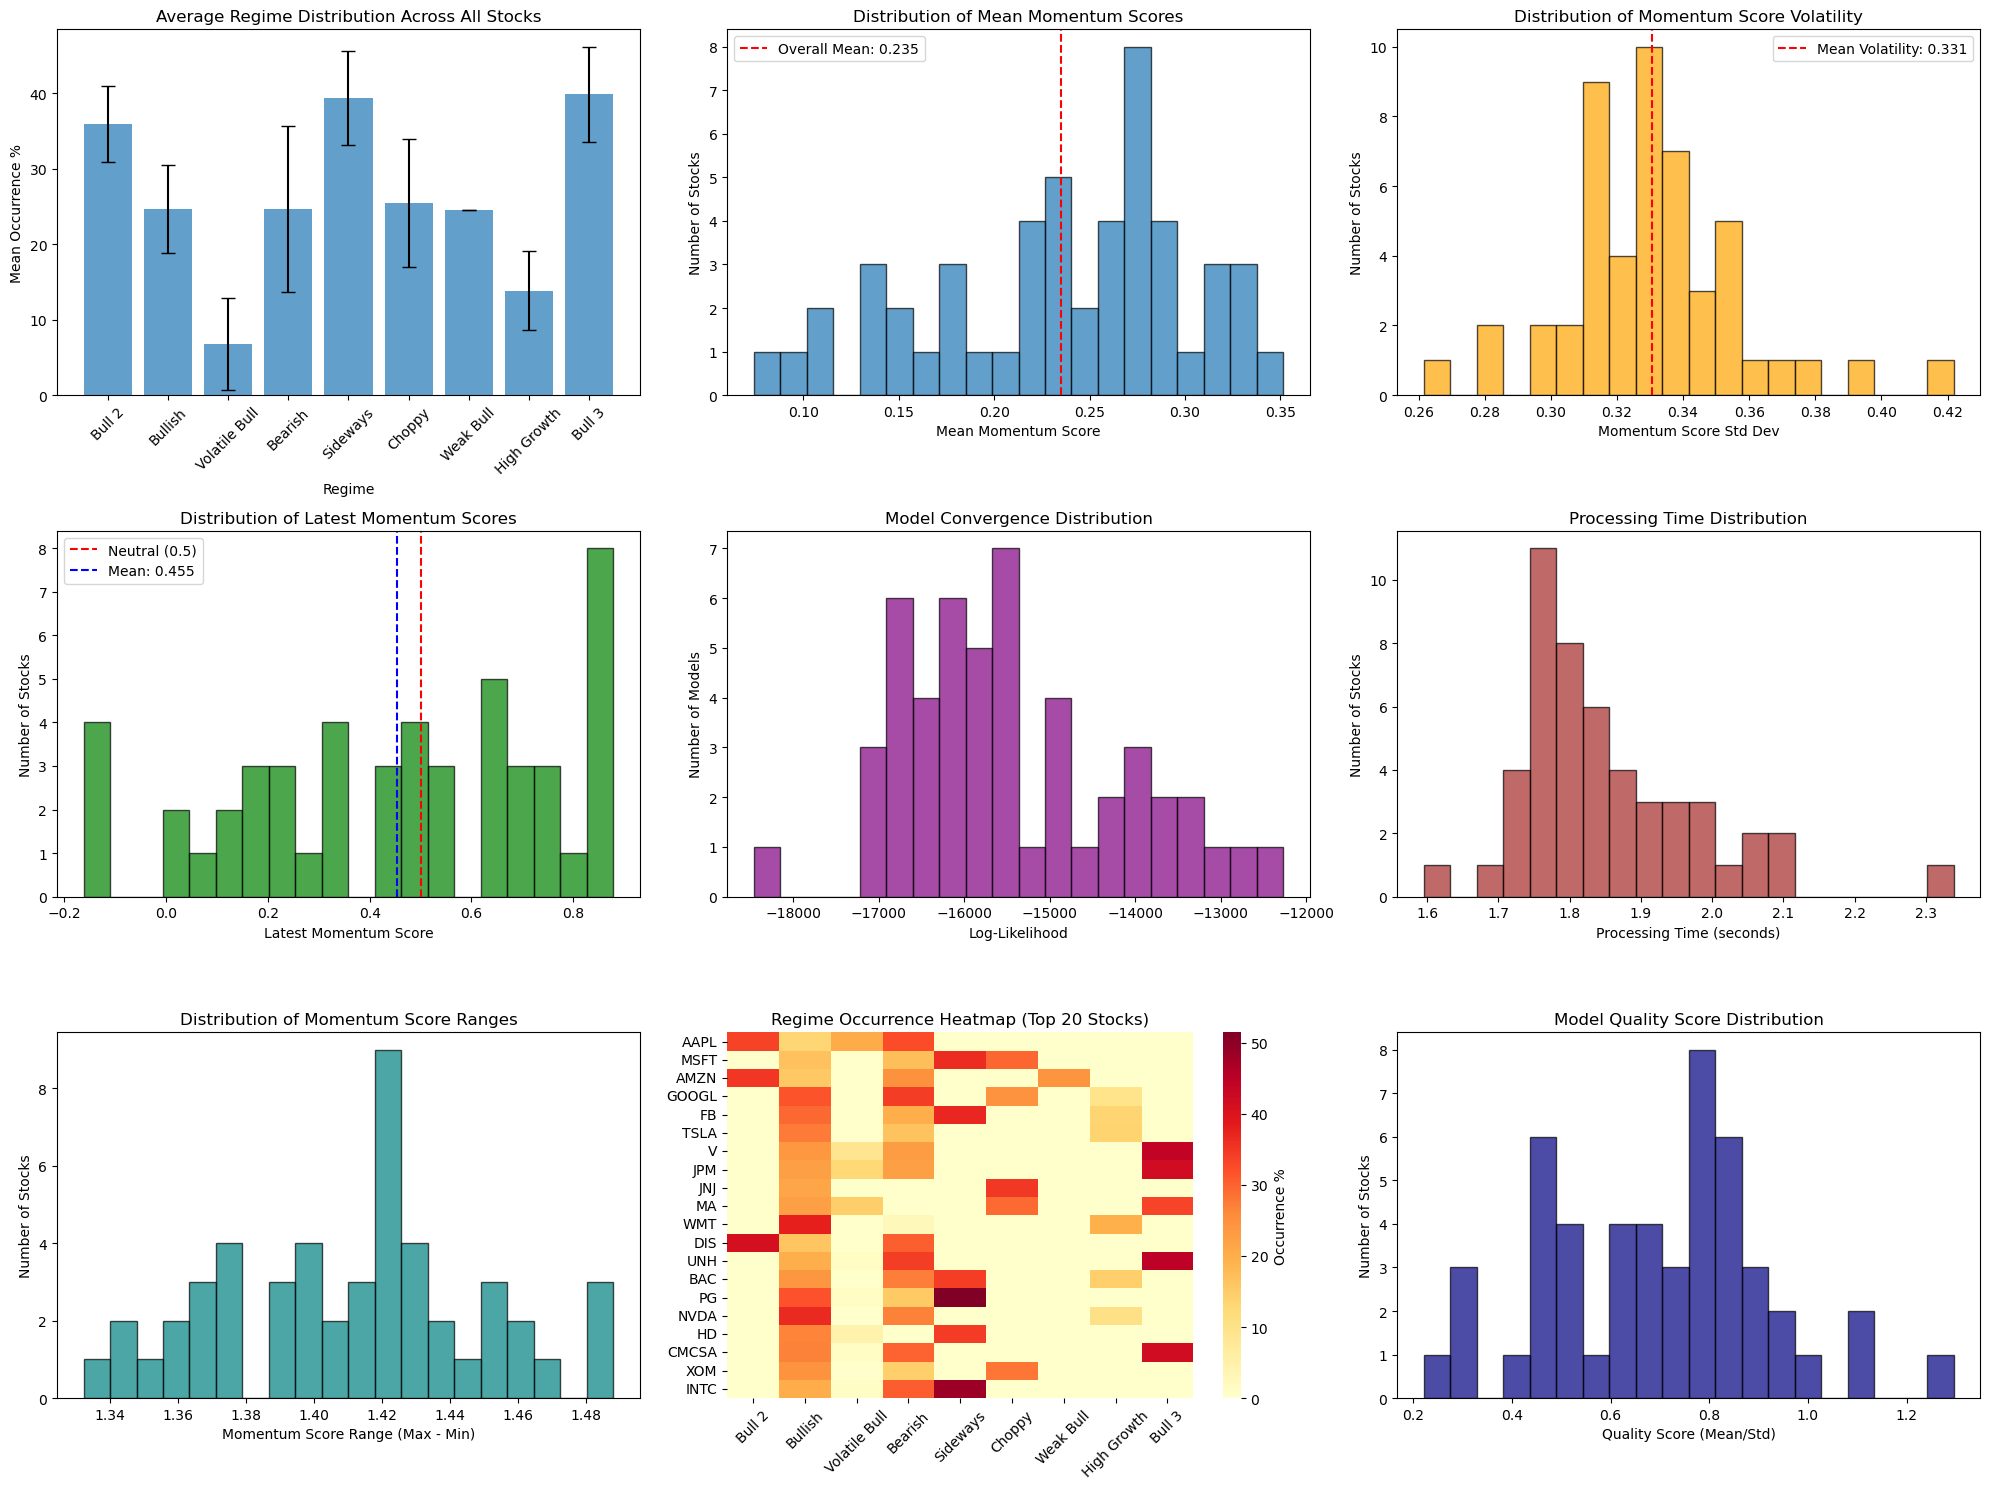


7. Creating Scientific Evaluation Visualizations...


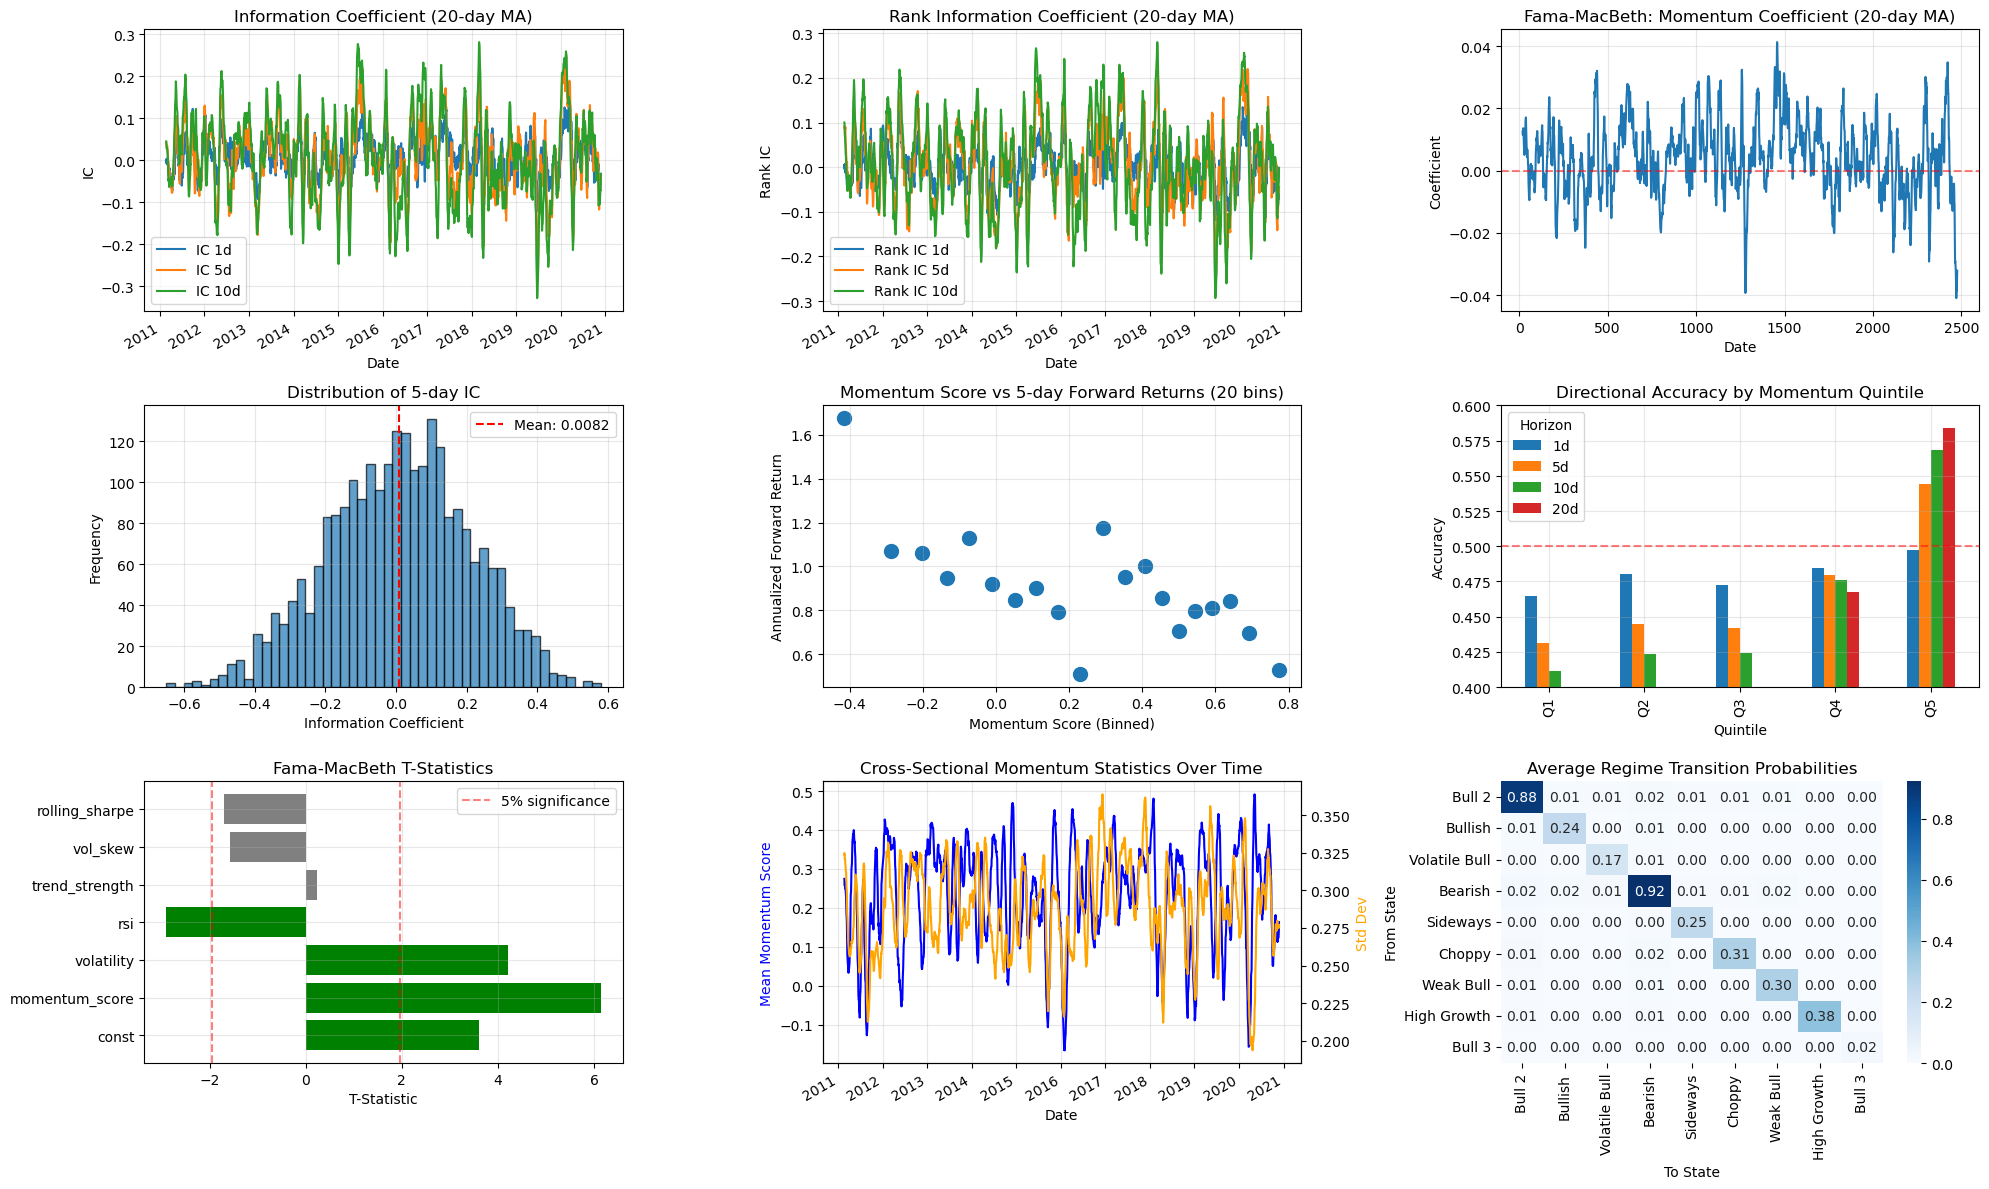


8. Exporting Comprehensive Results...
------------------------------------------------------------
✓ Exported: hmm_daily_scores_complete.csv
✓ Exported: hmm_information_coefficient_analysis.csv
✓ Exported: hmm_ic_timeseries.csv
✓ Exported: hmm_fama_macbeth_results.csv
✓ Exported: hmm_fama_macbeth_daily_coefficients.csv
✓ Exported: hmm_directional_accuracy.csv
✓ Exported: hmm_regime_analysis.csv
✓ Exported: hmm_average_transition_matrix.csv
✓ Exported: hmm_model_performance.csv
✓ Exported: hmm_momentum_statistics_by_ticker.csv
✓ Exported: hmm_evaluation_summary.csv

9. Calculating Additional Evaluation Metrics...
------------------------------------------------------------

• Score Stability Analysis
  - Average score autocorrelation (1-day): 0.825
  - Std dev of autocorrelation: 0.024

• Signal Turnover Analysis
  - Average daily turnover: 16.67%
  - Turnover std dev: 3.62%

• Cross-sectional Score Distribution
  - Average cross-sectional mean: 0.234
  - Average cross-sectional std: 0

In [2]:
# HMM Price Momentum Model - Comprehensive Scientific Evaluation
# This script runs the model on all 50 stocks and performs rigorous statistical evaluation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
from scipy import stats
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
warnings.filterwarnings('ignore')

# Make sure the PriceMomentumHMM class is already loaded

class ModelEvaluator:
    """
    Comprehensive evaluation framework for HMM Momentum Model
    """
    
    def __init__(self):
        self.results = {}
        self.daily_scores = []
        self.evaluation_metrics = {}
        
    def calculate_forward_returns(self, price_data, horizons=[1, 5, 10, 20]):
        """
        Calculate forward returns for different horizons
        """
        price_data = price_data.sort_values(['ticker', 'date'])
        
        for horizon in horizons:
            price_data[f'fwd_return_{horizon}d'] = (
                price_data.groupby('ticker')['close']
                .pct_change(horizon)
                .shift(-horizon)
            )
        
        return price_data
    
    def calculate_information_coefficient(self, scores_df, returns_df, horizons=[1, 5, 10, 20]):
        """
        Calculate Information Coefficient (IC) and Rank IC
        """
        ic_results = {}
        
        for horizon in horizons:
            return_col = f'fwd_return_{horizon}d'
            
            # Merge scores with returns
            merged = pd.merge(
                scores_df[['date', 'ticker', 'momentum_score']],
                returns_df[['date', 'ticker', return_col]],
                on=['date', 'ticker'],
                how='inner'
            )
            
            # Drop NaN values
            merged = merged.dropna()
            
            # Calculate IC by date
            ic_by_date = merged.groupby('date').apply(
                lambda x: x['momentum_score'].corr(x[return_col])
            )
            
            # Calculate Rank IC by date
            rank_ic_by_date = merged.groupby('date').apply(
                lambda x: x['momentum_score'].rank().corr(x[return_col].rank())
            )
            
            # Store results
            ic_results[f'{horizon}d'] = {
                'ic_mean': ic_by_date.mean(),
                'ic_std': ic_by_date.std(),
                'ic_ir': ic_by_date.mean() / ic_by_date.std() if ic_by_date.std() > 0 else 0,
                'ic_tstat': ic_by_date.mean() / (ic_by_date.std() / np.sqrt(len(ic_by_date))),
                'rank_ic_mean': rank_ic_by_date.mean(),
                'rank_ic_std': rank_ic_by_date.std(),
                'rank_ic_ir': rank_ic_by_date.mean() / rank_ic_by_date.std() if rank_ic_by_date.std() > 0 else 0,
                'ic_series': ic_by_date,
                'rank_ic_series': rank_ic_by_date
            }
        
        return ic_results
    
    def fama_macbeth_regression(self, scores_df, returns_df, horizon=5):
        """
        Perform Fama-MacBeth regression
        """
        return_col = f'fwd_return_{horizon}d'
        
        # Merge data
        merged = pd.merge(
            scores_df[['date', 'ticker', 'momentum_score', 'volatility', 
                      'rsi', 'trend_strength', 'vol_skew', 'rolling_sharpe']],
            returns_df[['date', 'ticker', return_col]],
            on=['date', 'ticker'],
            how='inner'
        ).dropna()
        
        # Run cross-sectional regressions for each date
        regression_results = []
        
        for date in merged['date'].unique():
            date_data = merged[merged['date'] == date]
            
            if len(date_data) < 10:  # Skip if too few observations
                continue
            
            # Prepare data
            y = date_data[return_col]
            X = date_data[['momentum_score', 'volatility', 'rsi', 
                          'trend_strength', 'vol_skew', 'rolling_sharpe']]
            X = sm.add_constant(X)
            
            try:
                # Run regression
                model = OLS(y, X).fit()
                
                # Store coefficients
                coeffs = model.params.to_dict()
                coeffs['date'] = date
                coeffs['r_squared'] = model.rsquared
                coeffs['nobs'] = model.nobs
                
                regression_results.append(coeffs)
            except:
                continue
        
        # Convert to DataFrame
        fama_macbeth_df = pd.DataFrame(regression_results)
        
        # Calculate time-series statistics
        fm_stats = {}
        for col in ['const', 'momentum_score', 'volatility', 'rsi', 
                    'trend_strength', 'vol_skew', 'rolling_sharpe']:
            if col in fama_macbeth_df.columns:
                series = fama_macbeth_df[col]
                fm_stats[col] = {
                    'mean': series.mean(),
                    'std': series.std(),
                    't_stat': series.mean() / (series.std() / np.sqrt(len(series))),
                    'p_value': 2 * (1 - stats.t.cdf(abs(series.mean() / (series.std() / np.sqrt(len(series)))), len(series) - 1))
                }
        
        return fm_stats, fama_macbeth_df
    
    def calculate_predictive_accuracy(self, scores_df, returns_df, horizons=[1, 5, 10, 20]):
        """
        Calculate directional accuracy metrics
        """
        accuracy_results = {}
        
        for horizon in horizons:
            return_col = f'fwd_return_{horizon}d'
            
            # Merge data
            merged = pd.merge(
                scores_df[['date', 'ticker', 'momentum_score', 'state_label']],
                returns_df[['date', 'ticker', return_col]],
                on=['date', 'ticker'],
                how='inner'
            ).dropna()
            
            # Create directional predictions
            merged['pred_direction'] = (merged['momentum_score'] > 0.5).astype(int)
            merged['actual_direction'] = (merged[return_col] > 0).astype(int)
            
            # Calculate accuracy metrics
            overall_accuracy = (merged['pred_direction'] == merged['actual_direction']).mean()
            
            # Accuracy by state
            state_accuracy = merged.groupby('state_label').apply(
                lambda x: (x['pred_direction'] == x['actual_direction']).mean()
            )
            
            # Accuracy by score quintile
            merged['score_quintile'] = pd.qcut(merged['momentum_score'], 5, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])
            quintile_accuracy = merged.groupby('score_quintile').apply(
                lambda x: (x['pred_direction'] == x['actual_direction']).mean()
            )
            
            accuracy_results[f'{horizon}d'] = {
                'overall_accuracy': overall_accuracy,
                'state_accuracy': state_accuracy,
                'quintile_accuracy': quintile_accuracy,
                'bullish_precision': merged[merged['pred_direction'] == 1]['actual_direction'].mean(),
                'bearish_precision': 1 - merged[merged['pred_direction'] == 0]['actual_direction'].mean()
            }
        
        return accuracy_results
    
    def calculate_regime_transition_statistics(self, all_results):
        """
        Calculate regime transition statistics across all stocks
        """
        # First, get all unique regimes across all stocks
        all_regimes = set()
        for ticker, result in all_results.items():
            all_regimes.update(result['scores']['state_label'].unique())
        all_regimes = sorted(list(all_regimes))
        
        # Create standardized transition matrices
        transition_matrices = []
        regime_durations = {}
        
        for ticker, result in all_results.items():
            scores = result['scores']
            states = scores['state_label'].values
            
            # Create transition matrix with all possible regimes
            trans_matrix = np.zeros((len(all_regimes), len(all_regimes)))
            
            for i in range(len(states) - 1):
                from_idx = all_regimes.index(states[i])
                to_idx = all_regimes.index(states[i + 1])
                trans_matrix[from_idx, to_idx] += 1
            
            # Normalize to probabilities (handle zero rows)
            row_sums = trans_matrix.sum(axis=1)
            for i in range(len(row_sums)):
                if row_sums[i] > 0:
                    trans_matrix[i, :] = trans_matrix[i, :] / row_sums[i]
            
            transition_matrices.append(trans_matrix)
            
            # Calculate regime durations
            current_regime = states[0]
            duration = 1
            
            for i in range(1, len(states)):
                if states[i] == current_regime:
                    duration += 1
                else:
                    if current_regime not in regime_durations:
                        regime_durations[current_regime] = []
                    regime_durations[current_regime].append(duration)
                    current_regime = states[i]
                    duration = 1
            
            # Add last duration
            if current_regime not in regime_durations:
                regime_durations[current_regime] = []
            regime_durations[current_regime].append(duration)
        
        # Calculate average transition matrix
        avg_trans_matrix = np.mean(transition_matrices, axis=0)
        
        # Calculate average durations
        avg_durations = {regime: np.mean(durations) for regime, durations in regime_durations.items()}
        
        return avg_trans_matrix, avg_durations, regime_durations, all_regimes


def run_comprehensive_evaluation():
    """
    Run comprehensive scientific evaluation of HMM model
    """
    print("="*80)
    print("HMM PRICE MOMENTUM MODEL - COMPREHENSIVE SCIENTIFIC EVALUATION")
    print("="*80)
    
    # Initialize evaluator
    evaluator = ModelEvaluator()
    
    # Load data
    print("\n1. Loading Data...")
    print("-"*60)
    
    price_data = pd.read_excel('filtered_russell_top50.xlsx')
    top50_tickers = pd.read_excel('Top50names2020.xlsx')['Ticker'].tolist()
    ptg_data = pd.read_excel('filtered_ptg_top50.xlsx')
    
    # Convert dates
    price_data['date'] = pd.to_datetime(price_data['date'])
    ptg_data['date'] = pd.to_datetime(ptg_data['date'])
    
    print(f"✓ Loaded price data: {len(price_data):,} records")
    print(f"✓ Loaded PTG data: {len(ptg_data):,} records")
    print(f"✓ Total tickers to analyze: {len(top50_tickers)}")
    
    # Calculate forward returns
    print("\n2. Calculating Forward Returns...")
    price_data = evaluator.calculate_forward_returns(price_data)
    
    # Run HMM model on all stocks
    print("\n3. Running HMM Model on All 50 Stocks...")
    print("-"*60)
    
    hmm_model = PriceMomentumHMM(n_states=4, n_iter=100, random_state=42)
    
    # Track model performance metrics
    model_metrics = {
        'successful_fits': 0,
        'failed_fits': 0,
        'insufficient_data': 0,
        'log_likelihoods': [],
        'regime_distributions': [],
        'momentum_score_stats': [],
        'processing_times': []
    }
    
    all_results = {}
    all_daily_scores = []
    failed_tickers = []
    insufficient_data_tickers = []
    
    for i, ticker in enumerate(top50_tickers):
        print(f"\rProcessing {i+1}/{len(top50_tickers)}: {ticker}...", end='')
        
        ticker_data = price_data[price_data['ticker'] == ticker].copy()
        ticker_data = ticker_data.sort_values('date').reset_index(drop=True)
        
        if len(ticker_data) < 252:
            model_metrics['insufficient_data'] += 1
            insufficient_data_tickers.append((ticker, len(ticker_data)))
            continue
        
        try:
            start_time = datetime.now()
            
            # Fit model
            hmm_model.fit(ticker, ticker_data)
            
            # Get results
            scores = hmm_model.calculate_momentum_scores(ticker)
            regime_summary = hmm_model.get_regime_summary(ticker)
            
            # Track metrics
            processing_time = (datetime.now() - start_time).total_seconds()
            model_metrics['processing_times'].append(processing_time)
            model_metrics['successful_fits'] += 1
            
            # Get model convergence info
            model = hmm_model.models[ticker]['model']
            model_metrics['log_likelihoods'].append(model.score(
                hmm_model.models[ticker]['scaler'].transform(
                    hmm_model.models[ticker]['processed_data'][hmm_model.models[ticker]['feature_names']].values
                )
            ))
            
            # Store results
            all_results[ticker] = {
                'scores': scores,
                'regime_summary': regime_summary,
                'processing_time': processing_time
            }
            
            # Collect regime distribution
            regime_dist = regime_summary.set_index('label')['occurrence_pct'].to_dict()
            model_metrics['regime_distributions'].append(regime_dist)
            
            # Collect momentum score statistics
            model_metrics['momentum_score_stats'].append({
                'ticker': ticker,
                'mean': scores['momentum_score'].mean(),
                'std': scores['momentum_score'].std(),
                'min': scores['momentum_score'].min(),
                'max': scores['momentum_score'].max(),
                'latest': scores['momentum_score'].iloc[-1]
            })
            
            # Collect daily scores
            all_daily_scores.append(scores)
            
        except Exception as e:
            model_metrics['failed_fits'] += 1
            failed_tickers.append((ticker, str(e)))
    
    print(f"\n✓ Successfully processed {len(all_results)} stocks")
    
    # Combine all daily scores
    daily_scores_df = pd.concat(all_daily_scores, ignore_index=True)
    
    # Model-Level Analysis
    print("\n4. Model-Level Performance Analysis")
    print("-"*60)
    
    # Success rate
    total_attempted = len(top50_tickers)
    success_rate = model_metrics['successful_fits'] / total_attempted * 100
    
    print(f"\nModel Fitting Summary:")
    print(f"  • Successful fits: {model_metrics['successful_fits']}/{total_attempted} ({success_rate:.1f}%)")
    print(f"  • Failed fits: {model_metrics['failed_fits']}")
    print(f"  • Insufficient data: {model_metrics['insufficient_data']}")
    
    if failed_tickers:
        print(f"\n  Failed tickers: {[t[0] for t in failed_tickers[:5]]}...")
    if insufficient_data_tickers:
        print(f"  Insufficient data: {[f'{t[0]}({t[1]} days)' for t in insufficient_data_tickers[:5]]}...")
    
    # Processing time statistics
    print(f"\nProcessing Time Statistics:")
    print(f"  • Mean: {np.mean(model_metrics['processing_times']):.2f} seconds")
    print(f"  • Std: {np.std(model_metrics['processing_times']):.2f} seconds")
    print(f"  • Total: {sum(model_metrics['processing_times']):.1f} seconds")
    
    # Model convergence
    print(f"\nModel Convergence (Log-Likelihood):")
    print(f"  • Mean: {np.mean(model_metrics['log_likelihoods']):.2f}")
    print(f"  • Std: {np.std(model_metrics['log_likelihoods']):.2f}")
    
    # Scientific Evaluation
    print("\n5. Performing Scientific Evaluation...")
    print("-"*60)
    
    # 5.1 Information Coefficient Analysis
    print("\n5.1 Information Coefficient Analysis")
    ic_results = evaluator.calculate_information_coefficient(daily_scores_df, price_data)
    
    print("\nInformation Coefficient (IC) Results:")
    print(f"{'Horizon':<10} {'IC Mean':<10} {'IC Std':<10} {'IC IR':<10} {'Rank IC':<10} {'t-stat':<10}")
    print("-"*60)
    for horizon, metrics in ic_results.items():
        print(f"{horizon:<10} {metrics['ic_mean']:>9.4f} {metrics['ic_std']:>9.4f} "
              f"{metrics['ic_ir']:>9.2f} {metrics['rank_ic_mean']:>9.4f} {metrics['ic_tstat']:>9.2f}")
    
    # 5.2 Fama-MacBeth Regression
    print("\n5.2 Fama-MacBeth Regression Results (5-day horizon)")
    fm_stats, fm_df = evaluator.fama_macbeth_regression(daily_scores_df, price_data, horizon=5)
    
    print(f"\n{'Variable':<20} {'Coefficient':<12} {'t-stat':<10} {'p-value':<10}")
    print("-"*50)
    for var, stats in fm_stats.items():
        print(f"{var:<20} {stats['mean']:>11.6f} {stats['t_stat']:>9.2f} {stats['p_value']:>9.4f}")
    
    # 5.3 Predictive Accuracy Analysis
    print("\n5.3 Directional Accuracy Analysis")
    accuracy_results = evaluator.calculate_predictive_accuracy(daily_scores_df, price_data)
    
    print(f"\n{'Horizon':<10} {'Accuracy':<12} {'Bullish Prec':<15} {'Bearish Prec':<15}")
    print("-"*50)
    for horizon, metrics in accuracy_results.items():
        print(f"{horizon:<10} {metrics['overall_accuracy']:>11.2%} "
              f"{metrics['bullish_precision']:>14.2%} {metrics['bearish_precision']:>14.2%}")
    
    # 5.4 Regime Analysis
    print("\n5.4 Regime Transition Analysis")
    avg_trans_matrix, avg_durations, all_durations, all_regimes = evaluator.calculate_regime_transition_statistics(all_results)
    
    print(f"\nAverage Regime Durations:")
    for regime, duration in avg_durations.items():
        print(f"  • {regime}: {duration:.1f} days")
    
    # Create comprehensive visualizations (Model-Level Focus)
    print("\n6. Creating Model-Level Visualizations...")
    print("-"*60)
    
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Average Regime Distribution Across All Stocks
    ax1 = plt.subplot(3, 3, 1)
    
    # Aggregate regime occurrences
    all_regimes = {}
    for dist in model_metrics['regime_distributions']:
        for regime, pct in dist.items():
            if regime not in all_regimes:
                all_regimes[regime] = []
            all_regimes[regime].append(pct)
    
    # Calculate mean occurrence for each regime
    regime_means = {regime: np.mean(pcts) for regime, pcts in all_regimes.items()}
    regime_stds = {regime: np.std(pcts) for regime, pcts in all_regimes.items()}
    
    regimes = list(regime_means.keys())
    means = list(regime_means.values())
    stds = list(regime_stds.values())
    
    ax1.bar(regimes, means, yerr=stds, capsize=5, alpha=0.7)
    ax1.set_xlabel('Regime')
    ax1.set_ylabel('Mean Occurrence %')
    ax1.set_title('Average Regime Distribution Across All Stocks')
    ax1.tick_params(axis='x', rotation=45)
    
    # 2. Momentum Score Distribution
    ax2 = plt.subplot(3, 3, 2)
    
    momentum_df = pd.DataFrame(model_metrics['momentum_score_stats'])
    ax2.hist(momentum_df['mean'], bins=20, alpha=0.7, edgecolor='black')
    ax2.axvline(momentum_df['mean'].mean(), color='red', linestyle='--', 
                label=f'Overall Mean: {momentum_df["mean"].mean():.3f}')
    ax2.set_xlabel('Mean Momentum Score')
    ax2.set_ylabel('Number of Stocks')
    ax2.set_title('Distribution of Mean Momentum Scores')
    ax2.legend()
    
    # 3. Momentum Score Volatility
    ax3 = plt.subplot(3, 3, 3)
    
    ax3.hist(momentum_df['std'], bins=20, alpha=0.7, color='orange', edgecolor='black')
    ax3.axvline(momentum_df['std'].mean(), color='red', linestyle='--',
                label=f'Mean Volatility: {momentum_df["std"].mean():.3f}')
    ax3.set_xlabel('Momentum Score Std Dev')
    ax3.set_ylabel('Number of Stocks')
    ax3.set_title('Distribution of Momentum Score Volatility')
    ax3.legend()
    
    # 4. Latest Momentum Scores
    ax4 = plt.subplot(3, 3, 4)
    
    ax4.hist(momentum_df['latest'], bins=20, alpha=0.7, color='green', edgecolor='black')
    ax4.axvline(0.5, color='red', linestyle='--', label='Neutral (0.5)')
    ax4.axvline(momentum_df['latest'].mean(), color='blue', linestyle='--',
                label=f'Mean: {momentum_df["latest"].mean():.3f}')
    ax4.set_xlabel('Latest Momentum Score')
    ax4.set_ylabel('Number of Stocks')
    ax4.set_title('Distribution of Latest Momentum Scores')
    ax4.legend()
    
    # 5. Model Convergence (Log-Likelihood)
    ax5 = plt.subplot(3, 3, 5)
    
    ax5.hist(model_metrics['log_likelihoods'], bins=20, alpha=0.7, color='purple', edgecolor='black')
    ax5.set_xlabel('Log-Likelihood')
    ax5.set_ylabel('Number of Models')
    ax5.set_title('Model Convergence Distribution')
    
    # 6. Processing Time Distribution
    ax6 = plt.subplot(3, 3, 6)
    
    ax6.hist(model_metrics['processing_times'], bins=20, alpha=0.7, color='brown', edgecolor='black')
    ax6.set_xlabel('Processing Time (seconds)')
    ax6.set_ylabel('Number of Stocks')
    ax6.set_title('Processing Time Distribution')
    
    # 7. Momentum Score Range
    ax7 = plt.subplot(3, 3, 7)
    
    ranges = momentum_df['max'] - momentum_df['min']
    ax7.hist(ranges, bins=20, alpha=0.7, color='teal', edgecolor='black')
    ax7.set_xlabel('Momentum Score Range (Max - Min)')
    ax7.set_ylabel('Number of Stocks')
    ax7.set_title('Distribution of Momentum Score Ranges')
    
    # 8. Regime Occurrence Heatmap
    ax8 = plt.subplot(3, 3, 8)
    
    # Create matrix of regime occurrences
    regime_matrix = []
    stock_labels = []
    
    for ticker, result in list(all_results.items())[:20]:  # First 20 stocks for visibility
        regime_summary = result['regime_summary']
        regime_dict = regime_summary.set_index('label')['occurrence_pct'].to_dict()
        
        row = []
        for regime in regimes:
            row.append(regime_dict.get(regime, 0))
        regime_matrix.append(row)
        stock_labels.append(ticker)
    
    if regime_matrix:
        sns.heatmap(regime_matrix, xticklabels=regimes, yticklabels=stock_labels,
                    cmap='YlOrRd', ax=ax8, cbar_kws={'label': 'Occurrence %'})
        ax8.set_title('Regime Occurrence Heatmap (Top 20 Stocks)')
        ax8.tick_params(axis='x', rotation=45)
    
    # 9. Model Quality Metrics
    ax9 = plt.subplot(3, 3, 9)
    
    # Calculate quality score for each stock
    quality_scores = []
    for _, stats in momentum_df.iterrows():
        # Quality = mean momentum / volatility (higher is better)
        quality = stats['mean'] / (stats['std'] + 0.01)
        quality_scores.append(quality)
    
    ax9.hist(quality_scores, bins=20, alpha=0.7, color='navy', edgecolor='black')
    ax9.set_xlabel('Quality Score (Mean/Std)')
    ax9.set_ylabel('Number of Stocks')
    ax9.set_title('Model Quality Score Distribution')
    
    plt.tight_layout()
    plt.savefig('hmm_model_evaluation.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Additional Scientific Visualizations
    print("\n7. Creating Scientific Evaluation Visualizations...")
    
    fig2 = plt.figure(figsize=(20, 12))
    
    # 1. IC Time Series
    ax1 = plt.subplot(3, 3, 1)
    for horizon, metrics in list(ic_results.items())[:3]:  # First 3 horizons
        metrics['ic_series'].rolling(20).mean().plot(ax=ax1, label=f'IC {horizon}')
    ax1.set_title('Information Coefficient (20-day MA)')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('IC')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Rank IC Time Series
    ax2 = plt.subplot(3, 3, 2)
    for horizon, metrics in list(ic_results.items())[:3]:
        metrics['rank_ic_series'].rolling(20).mean().plot(ax=ax2, label=f'Rank IC {horizon}')
    ax2.set_title('Rank Information Coefficient (20-day MA)')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Rank IC')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Fama-MacBeth Coefficients Over Time
    ax3 = plt.subplot(3, 3, 3)
    fm_df['momentum_score'].rolling(20).mean().plot(ax=ax3, label='Momentum Score Coef')
    ax3.axhline(y=0, color='r', linestyle='--', alpha=0.5)
    ax3.set_title('Fama-MacBeth: Momentum Coefficient (20-day MA)')
    ax3.set_xlabel('Date')
    ax3.set_ylabel('Coefficient')
    ax3.grid(True, alpha=0.3)
    
    # 4. IC Distribution
    ax4 = plt.subplot(3, 3, 4)
    ic_5d = ic_results['5d']['ic_series'].dropna()
    ax4.hist(ic_5d, bins=50, alpha=0.7, edgecolor='black')
    ax4.axvline(x=ic_5d.mean(), color='r', linestyle='--', 
                label=f'Mean: {ic_5d.mean():.4f}')
    ax4.set_title('Distribution of 5-day IC')
    ax4.set_xlabel('Information Coefficient')
    ax4.set_ylabel('Frequency')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. Momentum Score vs Forward Returns (Binned)
    ax5 = plt.subplot(3, 3, 5)
    merged_for_bins = pd.merge(
        daily_scores_df[['date', 'ticker', 'momentum_score']],
        price_data[['date', 'ticker', 'fwd_return_5d']],
        on=['date', 'ticker']
    ).dropna()
    
    merged_for_bins['score_bin'] = pd.qcut(merged_for_bins['momentum_score'], 20, labels=False)
    bin_returns = merged_for_bins.groupby('score_bin').agg({
        'momentum_score': 'mean',
        'fwd_return_5d': 'mean'
    })
    
    ax5.scatter(bin_returns['momentum_score'], bin_returns['fwd_return_5d'] * 252, s=100)
    ax5.set_xlabel('Momentum Score (Binned)')
    ax5.set_ylabel('Annualized Forward Return')
    ax5.set_title('Momentum Score vs 5-day Forward Returns (20 bins)')
    ax5.grid(True, alpha=0.3)
    
    # 6. Directional Accuracy by Score Quintile
    ax6 = plt.subplot(3, 3, 6)
    accuracy_by_q = pd.DataFrame({
        horizon: metrics['quintile_accuracy'].values
        for horizon, metrics in accuracy_results.items()
    }, index=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])
    
    accuracy_by_q.plot(kind='bar', ax=ax6)
    ax6.axhline(y=0.5, color='r', linestyle='--', alpha=0.5)
    ax6.set_title('Directional Accuracy by Momentum Quintile')
    ax6.set_xlabel('Quintile')
    ax6.set_ylabel('Accuracy')
    ax6.legend(title='Horizon')
    ax6.set_ylim(0.4, 0.6)
    ax6.grid(True, alpha=0.3)
    
    # 7. T-statistics of Fama-MacBeth Coefficients
    ax7 = plt.subplot(3, 3, 7)
    coef_names = list(fm_stats.keys())
    t_stats = [fm_stats[c]['t_stat'] for c in coef_names]
    colors = ['green' if abs(t) > 1.96 else 'gray' for t in t_stats]
    
    ax7.barh(range(len(coef_names)), t_stats, color=colors)
    ax7.set_yticks(range(len(coef_names)))
    ax7.set_yticklabels(coef_names)
    ax7.axvline(x=1.96, color='r', linestyle='--', alpha=0.5, label='5% significance')
    ax7.axvline(x=-1.96, color='r', linestyle='--', alpha=0.5)
    ax7.set_title('Fama-MacBeth T-Statistics')
    ax7.set_xlabel('T-Statistic')
    ax7.legend()
    ax7.grid(True, alpha=0.3)
    
    # 8. Cross-Sectional Momentum Distribution Over Time
    ax8 = plt.subplot(3, 3, 8)
    
    # Calculate cross-sectional statistics by date
    cs_stats = daily_scores_df.groupby('date')['momentum_score'].agg(['mean', 'std'])
    cs_stats['mean'].rolling(20).mean().plot(ax=ax8, label='Mean', color='blue')
    ax8_twin = ax8.twinx()
    cs_stats['std'].rolling(20).mean().plot(ax=ax8_twin, label='Std Dev', color='orange')
    
    ax8.set_ylabel('Mean Momentum Score', color='blue')
    ax8_twin.set_ylabel('Std Dev', color='orange')
    ax8.set_xlabel('Date')
    ax8.set_title('Cross-Sectional Momentum Statistics Over Time')
    ax8.grid(True, alpha=0.3)
    
    # 9. Regime Transition Matrix Heatmap
    ax9 = plt.subplot(3, 3, 9)
    
    # Use the average transition matrix
    if len(avg_trans_matrix) > 0:
        sns.heatmap(avg_trans_matrix, 
                    xticklabels=all_regimes, 
                    yticklabels=all_regimes,
                    annot=True, fmt='.2f', cmap='Blues', ax=ax9)
        ax9.set_title('Average Regime Transition Probabilities')
        ax9.set_xlabel('To State')
        ax9.set_ylabel('From State')
    
    plt.tight_layout()
    plt.savefig('hmm_scientific_evaluation.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Export comprehensive results
    print("\n8. Exporting Comprehensive Results...")
    print("-"*60)
    
    # 1. Export complete daily scores with all features
    daily_scores_df.to_csv('hmm_daily_scores_complete.csv', index=False)
    print("✓ Exported: hmm_daily_scores_complete.csv")
    
    # 2. Export IC analysis results
    ic_summary = pd.DataFrame({
        horizon: {
            'ic_mean': metrics['ic_mean'],
            'ic_std': metrics['ic_std'],
            'ic_ir': metrics['ic_ir'],
            'ic_tstat': metrics['ic_tstat'],
            'rank_ic_mean': metrics['rank_ic_mean'],
            'rank_ic_std': metrics['rank_ic_std'],
            'rank_ic_ir': metrics['rank_ic_ir']
        }
        for horizon, metrics in ic_results.items()
    }).T
    ic_summary.to_csv('hmm_information_coefficient_analysis.csv')
    print("✓ Exported: hmm_information_coefficient_analysis.csv")
    
    # Export IC time series
    ic_timeseries = pd.DataFrame({
        f'ic_{horizon}': metrics['ic_series']
        for horizon, metrics in ic_results.items()
    })
    ic_timeseries.to_csv('hmm_ic_timeseries.csv')
    print("✓ Exported: hmm_ic_timeseries.csv")
    
    # 3. Export Fama-MacBeth results
    fm_summary = pd.DataFrame(fm_stats).T
    fm_summary.to_csv('hmm_fama_macbeth_results.csv')
    fm_df.to_csv('hmm_fama_macbeth_daily_coefficients.csv', index=False)
    print("✓ Exported: hmm_fama_macbeth_results.csv")
    print("✓ Exported: hmm_fama_macbeth_daily_coefficients.csv")
    
    # 4. Export directional accuracy results
    accuracy_summary = pd.DataFrame({
        horizon: {
            'overall_accuracy': metrics['overall_accuracy'],
            'bullish_precision': metrics['bullish_precision'],
            'bearish_precision': metrics['bearish_precision']
        }
        for horizon, metrics in accuracy_results.items()
    }).T
    accuracy_summary.to_csv('hmm_directional_accuracy.csv')
    print("✓ Exported: hmm_directional_accuracy.csv")
    
    # 5. Export regime analysis
    regime_summary = pd.DataFrame({
        'regime': list(avg_durations.keys()),
        'avg_duration_days': list(avg_durations.values()),
        'total_occurrences': [len(all_durations[regime]) for regime in avg_durations.keys()]
    })
    regime_summary.to_csv('hmm_regime_analysis.csv', index=False)
    
    # Export transition matrix
    trans_matrix_df = pd.DataFrame(
        avg_trans_matrix,
        index=all_regimes,
        columns=all_regimes
    )
    trans_matrix_df.to_csv('hmm_average_transition_matrix.csv')
    print("✓ Exported: hmm_regime_analysis.csv")
    print("✓ Exported: hmm_average_transition_matrix.csv")
    
    # 6. Export model performance summary
    model_performance = pd.DataFrame([{
        'successful_fits': model_metrics['successful_fits'],
        'failed_fits': model_metrics['failed_fits'],
        'insufficient_data': model_metrics['insufficient_data'],
        'success_rate': success_rate,
        'mean_log_likelihood': np.mean(model_metrics['log_likelihoods']),
        'std_log_likelihood': np.std(model_metrics['log_likelihoods']),
        'mean_processing_time': np.mean(model_metrics['processing_times']),
        'total_processing_time': sum(model_metrics['processing_times'])
    }])
    model_performance.to_csv('hmm_model_performance.csv', index=False)
    print("✓ Exported: hmm_model_performance.csv")
    
    # 7. Export momentum statistics by ticker
    momentum_stats_df = pd.DataFrame(model_metrics['momentum_score_stats'])
    momentum_stats_df.to_csv('hmm_momentum_statistics_by_ticker.csv', index=False)
    print("✓ Exported: hmm_momentum_statistics_by_ticker.csv")
    
    # 8. Create master evaluation summary
    evaluation_summary = {
        'Model Performance': {
            'Stocks Analyzed': len(all_results),
            'Success Rate': f'{success_rate:.1f}%',
            'Total Days': len(daily_scores_df),
            'Date Range': f"{daily_scores_df['date'].min().strftime('%Y-%m-%d')} to {daily_scores_df['date'].max().strftime('%Y-%m-%d')}"
        },
        'Predictive Power (5-day)': {
            'Information Coefficient': f'{ic_results["5d"]["ic_mean"]:.4f}',
            'IC T-statistic': f'{ic_results["5d"]["ic_tstat"]:.2f}',
            'IC Information Ratio': f'{ic_results["5d"]["ic_ir"]:.2f}',
            'Rank IC': f'{ic_results["5d"]["rank_ic_mean"]:.4f}',
            'Directional Accuracy': f'{accuracy_results["5d"]["overall_accuracy"]:.2%}'
        },
        'Factor Significance': {
            'Momentum Score Coefficient': f'{fm_stats["momentum_score"]["mean"]:.6f}',
            'Momentum Score T-stat': f'{fm_stats["momentum_score"]["t_stat"]:.2f}',
            'Momentum Score P-value': f'{fm_stats["momentum_score"]["p_value"]:.4f}',
            'Significant at 5%': 'Yes' if fm_stats["momentum_score"]["p_value"] < 0.05 else 'No'
        },
        'Regime Characteristics': {
            'Most Common Regime': max(regime_means, key=regime_means.get),
            'Avg Regime Duration': f'{np.mean(list(avg_durations.values())):.1f} days',
            'Total Regime Types': len(avg_durations)
        },
        'Model Quality': {
            'Mean Momentum Score': f'{momentum_df["mean"].mean():.3f}',
            'Momentum Score Volatility': f'{momentum_df["std"].mean():.3f}',
            'Latest Market Sentiment': 'Bullish' if momentum_df['latest'].mean() > 0.5 else 'Bearish',
            'Mean Log-Likelihood': f'{np.mean(model_metrics["log_likelihoods"]):.1f}'
        }
    }
    
    # Flatten and export summary
    summary_rows = []
    for category, metrics in evaluation_summary.items():
        for metric, value in metrics.items():
            summary_rows.append({
                'Category': category,
                'Metric': metric,
                'Value': value
            })
    
    summary_df = pd.DataFrame(summary_rows)
    summary_df.to_csv('hmm_evaluation_summary.csv', index=False)
    print("✓ Exported: hmm_evaluation_summary.csv")
    
    # Calculate additional evaluation metrics
    print("\n9. Calculating Additional Evaluation Metrics...")
    print("-"*60)
    
    # 1. Score Stability Analysis
    print("\n• Score Stability Analysis")
    
    # Calculate autocorrelation
    autocorr_by_ticker = daily_scores_df.groupby('ticker')['momentum_score'].apply(
        lambda x: x.autocorr(lag=1) if len(x) > 1 else np.nan
    )
    
    print(f"  - Average score autocorrelation (1-day): {autocorr_by_ticker.mean():.3f}")
    print(f"  - Std dev of autocorrelation: {autocorr_by_ticker.std():.3f}")
    
    # 2. Signal Turnover Analysis
    print("\n• Signal Turnover Analysis")
    
    daily_scores_df['signal'] = (daily_scores_df['momentum_score'] > 0.5).astype(int)
    turnover_by_ticker = daily_scores_df.groupby('ticker').apply(
        lambda x: (x['signal'] != x['signal'].shift()).mean()
    )
    
    print(f"  - Average daily turnover: {turnover_by_ticker.mean():.2%}")
    print(f"  - Turnover std dev: {turnover_by_ticker.std():.2%}")
    
    # 3. Cross-sectional Analysis
    print("\n• Cross-sectional Score Distribution")
    
    cs_stats_full = daily_scores_df.groupby('date')['momentum_score'].agg(['mean', 'std', 'skew'])
    # Calculate kurtosis separately
    cs_kurtosis = daily_scores_df.groupby('date')['momentum_score'].apply(lambda x: x.kurtosis())
    
    print(f"  - Average cross-sectional mean: {cs_stats_full['mean'].mean():.3f}")
    print(f"  - Average cross-sectional std: {cs_stats_full['std'].mean():.3f}")
    print(f"  - Average cross-sectional skew: {cs_stats_full['skew'].mean():.3f}")
    print(f"  - Average cross-sectional kurtosis: {cs_kurtosis.mean():.3f}")
    
    # 4. Factor Correlation Analysis
    print("\n• Factor Correlation Analysis")
    
    factor_cols = ['momentum_score', 'trend_strength', 'volatility', 'rsi', 'vol_skew', 'rolling_sharpe']
    factor_corr = daily_scores_df[factor_cols].corr()
    
    print("\nTop correlations with momentum_score:")
    corr_with_score = factor_corr['momentum_score'].drop('momentum_score').sort_values(ascending=False)
    for factor, corr in corr_with_score.items():
        print(f"  - {factor}: {corr:.3f}")
    
    # Export additional metrics
    stability_df = pd.DataFrame({
        'ticker': autocorr_by_ticker.index,
        'score_autocorr': autocorr_by_ticker.values,
        'daily_turnover': turnover_by_ticker.values
    })
    stability_df.to_csv('hmm_stability_analysis.csv', index=False)
    
    # Add kurtosis to cross-sectional stats before exporting
    cs_stats_full['kurtosis'] = cs_kurtosis
    cs_stats_full.to_csv('hmm_cross_sectional_stats.csv')
    
    factor_corr.to_csv('hmm_factor_correlations.csv')
    
    print("\n✓ Exported: hmm_stability_analysis.csv")
    print("✓ Exported: hmm_cross_sectional_stats.csv")
    print("✓ Exported: hmm_factor_correlations.csv")
    
    # Final summary
    print("\n" + "="*80)
    print("EVALUATION COMPLETE")
    print("="*80)
    print(f"\nKey Findings:")
    print(f"• Information Coefficient (5d): {ic_results['5d']['ic_mean']:.4f} (t-stat: {ic_results['5d']['ic_tstat']:.2f})")
    print(f"• Rank IC (5d): {ic_results['5d']['rank_ic_mean']:.4f} (IR: {ic_results['5d']['rank_ic_ir']:.2f})")
    print(f"• Directional Accuracy (5d): {accuracy_results['5d']['overall_accuracy']:.2%}")
    print(f"• Momentum Factor t-stat: {fm_stats['momentum_score']['t_stat']:.2f} (p={fm_stats['momentum_score']['p_value']:.4f})")
    print(f"• Score Autocorrelation: {autocorr_by_ticker.mean():.3f}")
    print(f"• Average Daily Turnover: {turnover_by_ticker.mean():.2%}")
    
    print("\nAll results have been exported to CSV files for further analysis.")
    
    return {
        'daily_scores': daily_scores_df,
        'ic_results': ic_results,
        'fm_results': (fm_stats, fm_df),
        'accuracy_results': accuracy_results,
        'regime_analysis': (avg_trans_matrix, avg_durations, regime_summary, all_regimes),
        'all_results': all_results,
        'model_metrics': model_metrics
    }


# Run the comprehensive evaluation
if __name__ == "__main__":
    evaluation_results = run_comprehensive_evaluation()

In [5]:
# HMM Out-of-Sample Prediction - Direct Execution
# This script will run immediately and generate predictions

import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("HMM PRICE MOMENTUM MODEL - OUT-OF-SAMPLE PREDICTION (2020-2024)")
print("="*70)

# Load new data
print("\n1. Loading 2020-2024 Data...")
new_data = pd.read_csv('OHLCV_2020-12-24_to_2024-12-24_stooq.csv')
new_data.columns = new_data.columns.str.lower()
new_data['date'] = pd.to_datetime(new_data['date'])
new_data = new_data.sort_values(['ticker', 'date']).reset_index(drop=True)

print(f"✓ Loaded {len(new_data):,} records")
print(f"✓ Date range: {new_data['date'].min()} to {new_data['date'].max()}")

# Load original training data and ticker list
print("\n2. Loading Original Training Data...")
training_data = pd.read_excel('filtered_russell_top50.xlsx')
training_data['date'] = pd.to_datetime(training_data['date'])
top50_tickers = pd.read_excel('Top50names2020.xlsx')['Ticker'].tolist()

# Find common tickers
available_tickers = list(set(new_data['ticker'].unique()) & set(top50_tickers))
print(f"✓ Tickers available for prediction: {len(available_tickers)}")

# Initialize model
print("\n3. Initializing HMM Model...")
hmm_model = PriceMomentumHMM(n_states=4, n_iter=100, random_state=42)

# Storage for predictions
all_predictions = []
successful_tickers = []
failed_tickers = []

# Process each ticker
print("\n4. Training Models and Making Predictions...")
print("-"*50)

for i, ticker in enumerate(available_tickers):
    if i % 5 == 0:  # Print progress every 5 tickers
        print(f"Processing {i+1}/{len(available_tickers)}: {ticker}...")
    
    try:
        # Get training data for this ticker
        train_ticker_data = training_data[training_data['ticker'] == ticker].copy()
        train_ticker_data = train_ticker_data.sort_values('date').reset_index(drop=True)
        
        if len(train_ticker_data) < 252:
            failed_tickers.append((ticker, "Insufficient training data"))
            continue
        
        # Fit model on training data (2010-2020)
        hmm_model.fit(ticker, train_ticker_data)
        
        # Get new data for this ticker (2020-2024)
        new_ticker_data = new_data[new_data['ticker'] == ticker].copy()
        new_ticker_data = new_ticker_data.sort_values('date').reset_index(drop=True)
        
        if len(new_ticker_data) < 20:
            failed_tickers.append((ticker, "Insufficient new data"))
            continue
        
        # Process new data through the feature engineering pipeline
        processed_new_data = hmm_model._engineer_features(new_ticker_data)
        
        # Get the trained model components
        model = hmm_model.models[ticker]['model']
        scaler = hmm_model.models[ticker]['scaler']
        feature_names = hmm_model.models[ticker]['feature_names']
        
        # Extract and scale features
        features = processed_new_data[feature_names].values
        features_scaled = scaler.transform(features)
        
        # Predict states and probabilities
        states = model.predict(features_scaled)
        state_probs = model.predict_proba(features_scaled)
        
        # Get regime statistics from training
        regime_stats = hmm_model.models[ticker].get('regime_stats')
        if regime_stats is None:
            # Calculate regime stats if not available
            train_features = hmm_model.models[ticker]['processed_data'][feature_names].values
            train_features_scaled = scaler.transform(train_features)
            train_states = model.predict(train_features_scaled)
            regime_stats = hmm_model._calculate_regime_stats(train_states, hmm_model.models[ticker]['processed_data'])
        
        # Calculate momentum scores for new data
        momentum_scores = []
        positive_states = [state for state, stats in regime_stats.items() 
                          if stats['mean_return'] > 0]
        
        for j in range(len(processed_new_data)):
            current_probs = state_probs[j]
            
            # Calculate score components
            positive_prob = sum(current_probs[state] for state in positive_states)
            trend_strength = processed_new_data.iloc[j]['momentum_20']
            vol_adj_return = (processed_new_data.iloc[j]['returns'] / 
                            (processed_new_data.iloc[j]['volatility'] + 1e-10))
            rsi_momentum = (processed_new_data.iloc[j]['rsi'] - 50) / 50
            
            vol_skew = processed_new_data.iloc[j]['vol_skew']
            sharpe = processed_new_data.iloc[j]['rolling_sharpe']
            
            if vol_skew > 1 and sharpe > 0:
                vol_quality = np.tanh((vol_skew - 1) * sharpe)
            elif vol_skew < 1 and sharpe < 0:
                vol_quality = -np.tanh((1 - vol_skew) * abs(sharpe))
            else:
                vol_quality = 0
            
            high_growth_bonus = 0
            for state, stats in regime_stats.items():
                if stats['label'] == 'High Growth':
                    high_growth_bonus = current_probs[state] * (1 + vol_quality) * 0.15
            
            # Final momentum score
            momentum_score = (
                0.30 * positive_prob +
                0.25 * np.tanh(trend_strength * 10) +
                0.15 * np.tanh(vol_adj_return) +
                0.10 * rsi_momentum +
                0.10 * vol_quality +
                0.10 * high_growth_bonus
            )
            
            momentum_scores.append(momentum_score)
        
        # Create output DataFrame
        scores_df = pd.DataFrame({
            'date': processed_new_data['date'].values,
            'ticker': ticker,
            'momentum_score': momentum_scores,
            'bullish_probability': [sum(state_probs[i][state] for state in positive_states) 
                                   for i in range(len(processed_new_data))],
            'current_state': states,
            'state_label': [regime_stats[state]['label'] for state in states],
            'trend_strength': processed_new_data['momentum_20'].values,
            'volatility': processed_new_data['volatility'].values,
            'rsi': processed_new_data['rsi'].values,
            'vol_skew': processed_new_data['vol_skew'].values,
            'rolling_sharpe': processed_new_data['rolling_sharpe'].values,
            'downside_vol': processed_new_data['downside_deviation'].values
        })
        
        all_predictions.append(scores_df)
        successful_tickers.append(ticker)
        
    except Exception as e:
        failed_tickers.append((ticker, str(e)))
        continue

print(f"\n✓ Processing complete!")
print(f"  • Successful: {len(successful_tickers)} tickers")
print(f"  • Failed: {len(failed_tickers)} tickers")

# Combine and export results
if all_predictions:
    print("\n5. Combining Results...")
    daily_predictions_df = pd.concat(all_predictions, ignore_index=True)
    
    # Summary statistics
    print("\n6. Out-of-Sample Statistics:")
    print("-"*50)
    print(f"  • Total predictions: {len(daily_predictions_df):,} days")
    print(f"  • Date range: {daily_predictions_df['date'].min()} to {daily_predictions_df['date'].max()}")
    print(f"  • Mean momentum score: {daily_predictions_df['momentum_score'].mean():.3f}")
    print(f"  • Std momentum score: {daily_predictions_df['momentum_score'].std():.3f}")
    
    # Latest market sentiment
    latest_date = daily_predictions_df['date'].max()
    latest_scores = daily_predictions_df[daily_predictions_df['date'] == latest_date]
    print(f"  • Latest date: {latest_date}")
    print(f"  • Latest mean score: {latest_scores['momentum_score'].mean():.3f}")
    print(f"  • Market sentiment: {'Bullish' if latest_scores['momentum_score'].mean() > 0.5 else 'Bearish'}")
    
    # Regime distribution
    print("\n  Regime Distribution (2020-2024):")
    regime_dist = daily_predictions_df['state_label'].value_counts(normalize=True) * 100
    for regime, pct in regime_dist.items():
        print(f"    • {regime}: {pct:.1f}%")
    
    # Export results
    print("\n7. Exporting Results...")
    output_filename = 'hmm_daily_scores_complete_2020_2024.csv'
    daily_predictions_df.to_csv(output_filename, index=False)
    print(f"✓ Exported: {output_filename} ({len(daily_predictions_df):,} rows)")
    
    # Also export a summary by ticker
    ticker_summary = daily_predictions_df.groupby('ticker').agg({
        'momentum_score': ['mean', 'std', 'min', 'max'],
        'date': ['min', 'max', 'count']
    }).round(3)
    ticker_summary.columns = ['_'.join(col).strip() for col in ticker_summary.columns]
    ticker_summary = ticker_summary.reset_index()
    ticker_summary.to_csv('hmm_ticker_summary_2020_2024.csv', index=False)
    print(f"✓ Exported: hmm_ticker_summary_2020_2024.csv")
    
    print("\n" + "="*70)
    print("OUT-OF-SAMPLE PREDICTION COMPLETE!")
    print("="*70)
    
else:
    print("\n✗ No successful predictions were made.")
    print("Failed tickers:")
    for ticker, reason in failed_tickers[:10]:
        print(f"  • {ticker}: {reason}")

HMM PRICE MOMENTUM MODEL - OUT-OF-SAMPLE PREDICTION (2020-2024)

1. Loading 2020-2024 Data...
✓ Loaded 49,294 records
✓ Date range: 2020-12-24 00:00:00 to 2024-12-24 00:00:00

2. Loading Original Training Data...
✓ Tickers available for prediction: 49

3. Initializing HMM Model...

4. Training Models and Making Predictions...
--------------------------------------------------
Processing 1/49: C...
Model fitted for C
Model fitted for BMY
Model fitted for NKE
Model fitted for DIS
Model fitted for INTC
Processing 6/49: WMT...
Model fitted for WMT
Model fitted for UNH
Model fitted for ADBE
Model fitted for UPS
Model fitted for MRK
Processing 11/49: AVGO...
Model fitted for AVGO
Model fitted for QCOM
Model fitted for AMZN
Model fitted for MCD
Model fitted for JPM
Processing 16/49: COST...
Model fitted for COST
Model fitted for MA
Model fitted for XOM
Model fitted for JNJ
Model fitted for CMCSA
Processing 21/49: PFE...
Model fitted for PFE
Model fitted for V
Model fitted for PEP
Model fitted

HMM MODEL - OUT-OF-SAMPLE EVALUATION AND COMPARISON

1. Loading Data...
------------------------------------------------------------
✓ Loaded OOS predictions: 48,314 records
✓ Loaded OOS price data: 49,294 records
✓ Loaded IS predictions: 123,498 records

2. Calculating Forward Returns...

3. Performing Scientific Evaluation...
------------------------------------------------------------

3.1 Information Coefficient Analysis

Out-of-Sample IC Results:
Horizon    IC Mean    IC Std     IC IR      Rank IC    t-stat    
------------------------------------------------------------
1d            0.0129    0.2363      0.05    0.0135      1.72
5d            0.0084    0.2187      0.04    0.0100      1.21
10d           0.0039    0.2040      0.02    0.0023      0.60
20d          -0.0018    0.2017     -0.01   -0.0006     -0.28

3.2 Fama-MacBeth Regression (5-day horizon)

Variable             Coefficient  t-stat     p-value   
--------------------------------------------------
const               

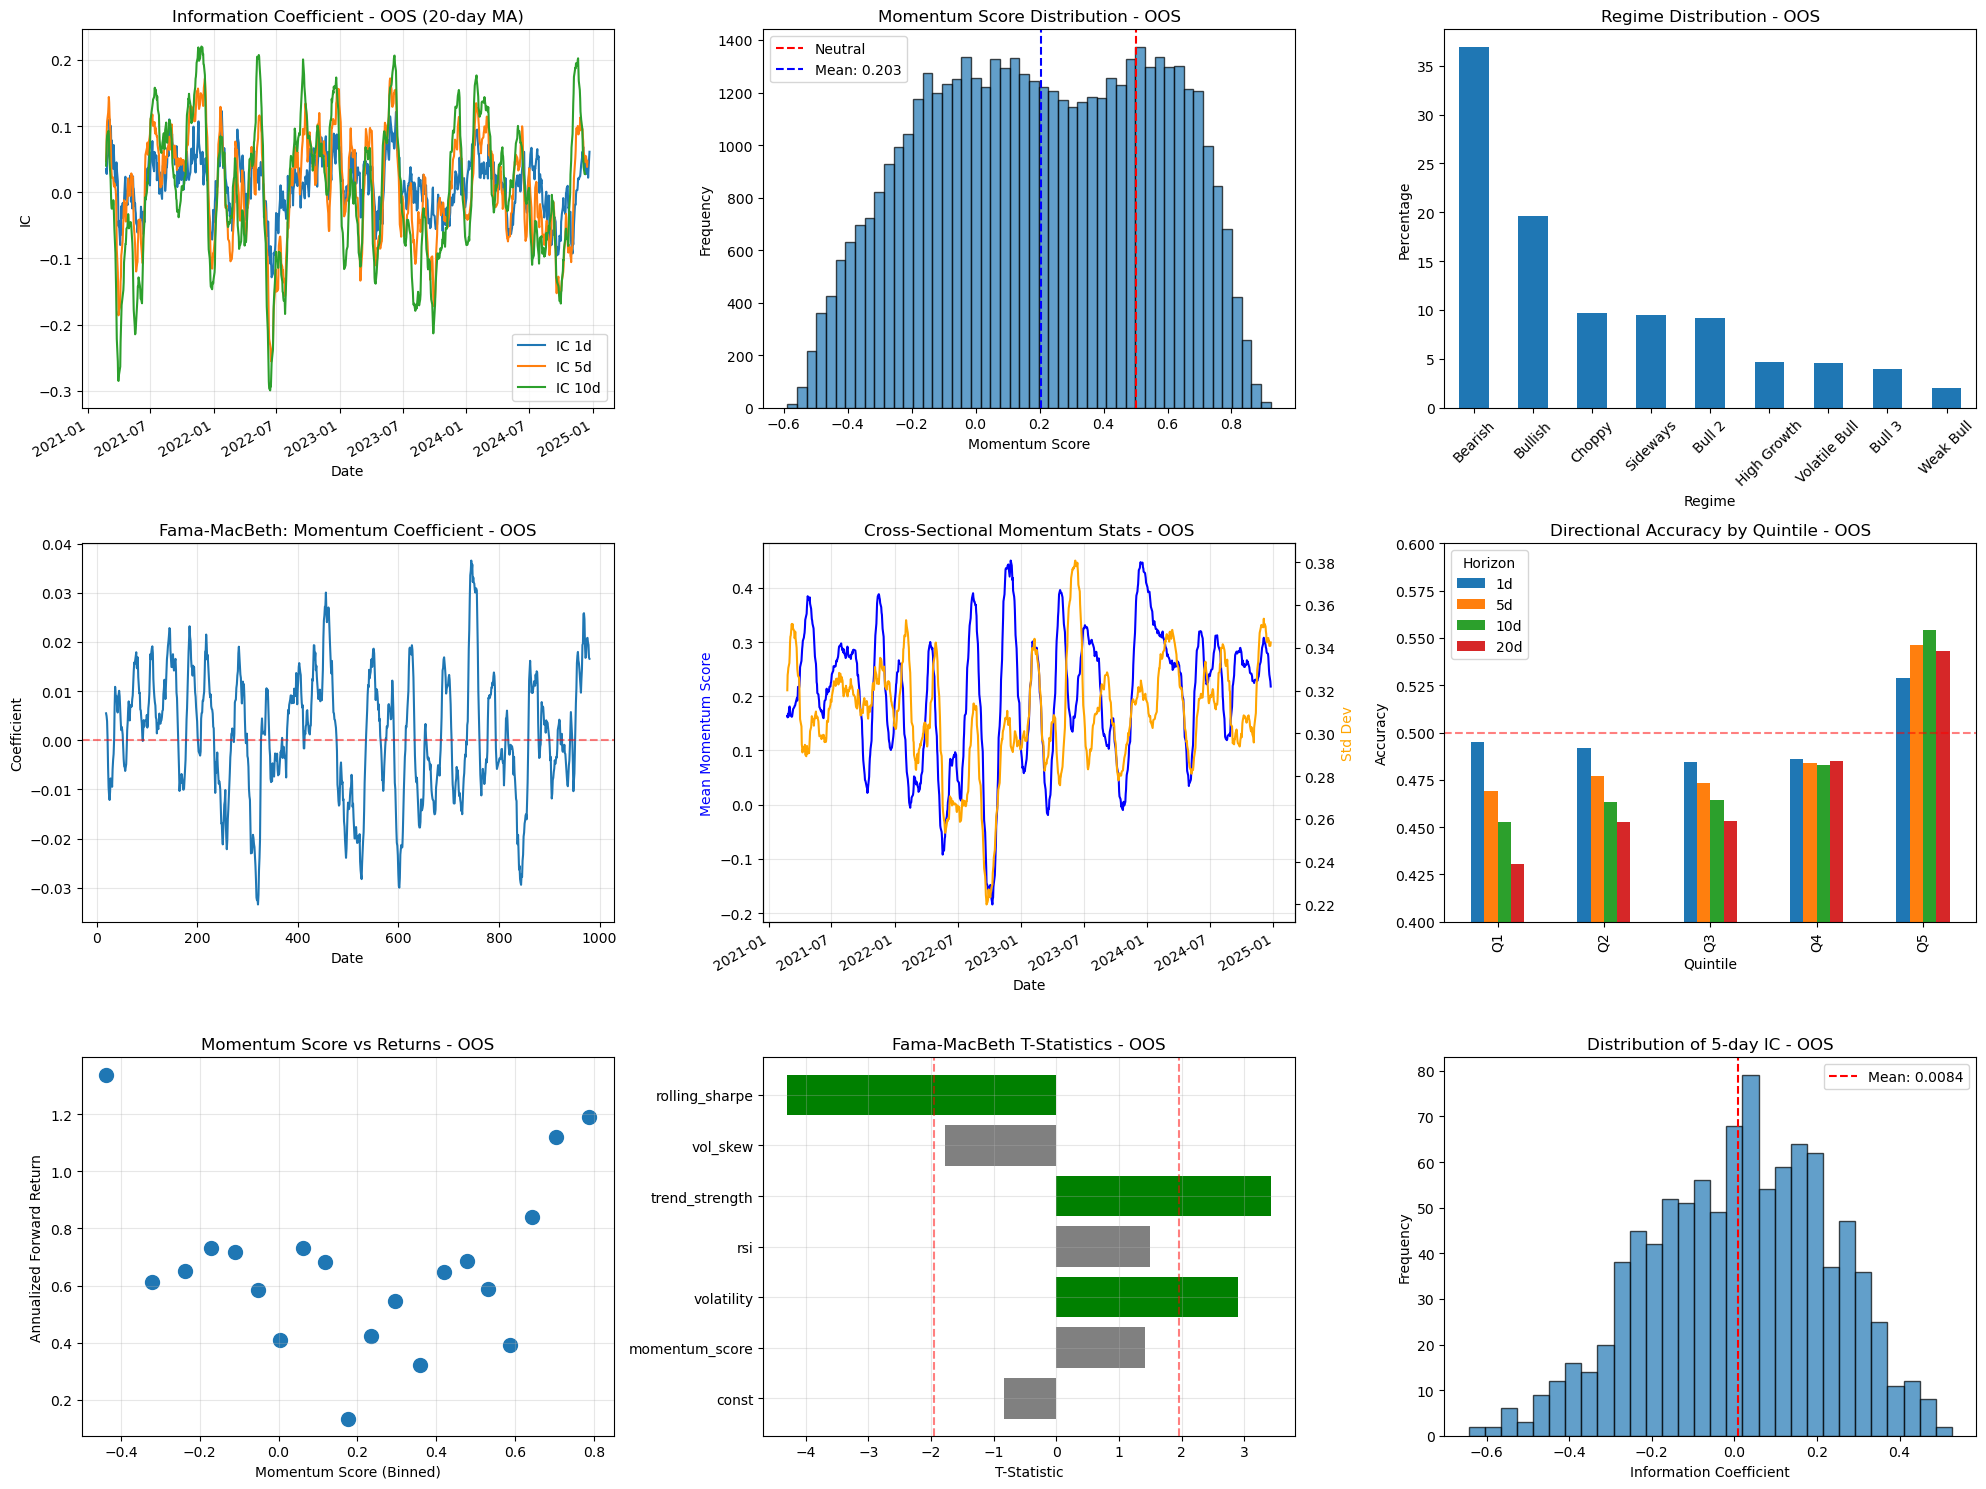


6. In-Sample vs Out-of-Sample Comparison
------------------------------------------------------------

Model Performance Comparison:
                  Period Total Days  Mean Score  Score Std   IC (5d)  IC IR (5d)  Rank IC (5d)  Accuracy (5d)  Mom Coef  Mom t-stat  Autocorr  Turnover
0        2020-2024 (OOS)      48314    0.203244   0.350828  0.008437    0.038577      0.010011       0.489921  0.001625    1.411916  0.836598  0.135985
1         2010-2020 (IS)     123498    0.234539   0.338488  0.008191    0.040757      0.006657       0.468348  0.004157    6.141215       N/A       N/A
2  Difference (OOS - IS)          -   -0.031296   0.012340  0.000246   -0.002179      0.003354       0.021573 -0.002533   -4.729299         -         -

✓ Exported: hmm_is_oos_comparison.csv

7. Exporting OOS Evaluation Results...
------------------------------------------------------------
✓ Exported: hmm_oos_information_coefficient.csv
✓ Exported: hmm_oos_fama_macbeth_results.csv
✓ Exported: hmm_oos_direc

In [7]:
# HMM Out-of-Sample Evaluation and Comparison
# This script evaluates the 2020-2024 predictions and compares with 2010-2020 results

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
from scipy import stats
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
warnings.filterwarnings('ignore')

class OutOfSampleEvaluator:
    """
    Evaluator for out-of-sample HMM predictions
    """
    
    def __init__(self):
        self.evaluation_metrics = {}
        
    def calculate_forward_returns(self, price_data, horizons=[1, 5, 10, 20]):
        """Calculate forward returns for different horizons"""
        price_data = price_data.sort_values(['ticker', 'date'])
        
        for horizon in horizons:
            price_data[f'fwd_return_{horizon}d'] = (
                price_data.groupby('ticker')['close']
                .pct_change(horizon)
                .shift(-horizon)
            )
        
        return price_data
    
    def calculate_information_coefficient(self, scores_df, returns_df, horizons=[1, 5, 10, 20]):
        """Calculate Information Coefficient (IC) and Rank IC"""
        ic_results = {}
        
        for horizon in horizons:
            return_col = f'fwd_return_{horizon}d'
            
            merged = pd.merge(
                scores_df[['date', 'ticker', 'momentum_score']],
                returns_df[['date', 'ticker', return_col]],
                on=['date', 'ticker'],
                how='inner'
            ).dropna()
            
            # Calculate IC by date
            ic_by_date = merged.groupby('date').apply(
                lambda x: x['momentum_score'].corr(x[return_col]) if len(x) > 1 else np.nan
            ).dropna()
            
            # Calculate Rank IC by date
            rank_ic_by_date = merged.groupby('date').apply(
                lambda x: x['momentum_score'].rank().corr(x[return_col].rank()) if len(x) > 1 else np.nan
            ).dropna()
            
            # Store results
            ic_results[f'{horizon}d'] = {
                'ic_mean': ic_by_date.mean(),
                'ic_std': ic_by_date.std(),
                'ic_ir': ic_by_date.mean() / ic_by_date.std() if ic_by_date.std() > 0 else 0,
                'ic_tstat': ic_by_date.mean() / (ic_by_date.std() / np.sqrt(len(ic_by_date))) if len(ic_by_date) > 0 else 0,
                'rank_ic_mean': rank_ic_by_date.mean(),
                'rank_ic_std': rank_ic_by_date.std(),
                'rank_ic_ir': rank_ic_by_date.mean() / rank_ic_by_date.std() if rank_ic_by_date.std() > 0 else 0,
                'ic_series': ic_by_date,
                'rank_ic_series': rank_ic_by_date
            }
        
        return ic_results
    
    def fama_macbeth_regression(self, scores_df, returns_df, horizon=5):
        """Perform Fama-MacBeth regression"""
        return_col = f'fwd_return_{horizon}d'
        
        merged = pd.merge(
            scores_df[['date', 'ticker', 'momentum_score', 'volatility', 
                      'rsi', 'trend_strength', 'vol_skew', 'rolling_sharpe']],
            returns_df[['date', 'ticker', return_col]],
            on=['date', 'ticker'],
            how='inner'
        ).dropna()
        
        regression_results = []
        
        for date in merged['date'].unique():
            date_data = merged[merged['date'] == date]
            
            if len(date_data) < 10:
                continue
            
            y = date_data[return_col]
            X = date_data[['momentum_score', 'volatility', 'rsi', 
                          'trend_strength', 'vol_skew', 'rolling_sharpe']]
            X = sm.add_constant(X)
            
            try:
                model = OLS(y, X).fit()
                coeffs = model.params.to_dict()
                coeffs['date'] = date
                coeffs['r_squared'] = model.rsquared
                coeffs['nobs'] = model.nobs
                regression_results.append(coeffs)
            except:
                continue
        
        fama_macbeth_df = pd.DataFrame(regression_results)
        
        fm_stats = {}
        for col in ['const', 'momentum_score', 'volatility', 'rsi', 
                    'trend_strength', 'vol_skew', 'rolling_sharpe']:
            if col in fama_macbeth_df.columns:
                series = fama_macbeth_df[col]
                fm_stats[col] = {
                    'mean': series.mean(),
                    'std': series.std(),
                    't_stat': series.mean() / (series.std() / np.sqrt(len(series))),
                    'p_value': 2 * (1 - stats.t.cdf(abs(series.mean() / (series.std() / np.sqrt(len(series)))), len(series) - 1))
                }
        
        return fm_stats, fama_macbeth_df
    
    def calculate_predictive_accuracy(self, scores_df, returns_df, horizons=[1, 5, 10, 20]):
        """Calculate directional accuracy metrics"""
        accuracy_results = {}
        
        for horizon in horizons:
            return_col = f'fwd_return_{horizon}d'
            
            merged = pd.merge(
                scores_df[['date', 'ticker', 'momentum_score', 'state_label']],
                returns_df[['date', 'ticker', return_col]],
                on=['date', 'ticker'],
                how='inner'
            ).dropna()
            
            merged['pred_direction'] = (merged['momentum_score'] > 0.5).astype(int)
            merged['actual_direction'] = (merged[return_col] > 0).astype(int)
            
            overall_accuracy = (merged['pred_direction'] == merged['actual_direction']).mean()
            
            # Accuracy by state
            state_accuracy = merged.groupby('state_label').apply(
                lambda x: (x['pred_direction'] == x['actual_direction']).mean()
            )
            
            # Accuracy by score quintile
            merged['score_quintile'] = pd.qcut(merged['momentum_score'], 5, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])
            quintile_accuracy = merged.groupby('score_quintile').apply(
                lambda x: (x['pred_direction'] == x['actual_direction']).mean()
            )
            
            accuracy_results[f'{horizon}d'] = {
                'overall_accuracy': overall_accuracy,
                'state_accuracy': state_accuracy,
                'quintile_accuracy': quintile_accuracy,
                'bullish_precision': merged[merged['pred_direction'] == 1]['actual_direction'].mean() if len(merged[merged['pred_direction'] == 1]) > 0 else np.nan,
                'bearish_precision': 1 - merged[merged['pred_direction'] == 0]['actual_direction'].mean() if len(merged[merged['pred_direction'] == 0]) > 0 else np.nan
            }
        
        return accuracy_results


def run_oos_evaluation_and_comparison():
    """
    Run comprehensive evaluation on out-of-sample data and compare with in-sample
    """
    print("="*80)
    print("HMM MODEL - OUT-OF-SAMPLE EVALUATION AND COMPARISON")
    print("="*80)
    
    evaluator = OutOfSampleEvaluator()
    
    # 1. Load data
    print("\n1. Loading Data...")
    print("-"*60)
    
    # Load OOS predictions
    oos_predictions = pd.read_csv('hmm_daily_scores_complete_2020_2024.csv')
    oos_predictions['date'] = pd.to_datetime(oos_predictions['date'])
    print(f"✓ Loaded OOS predictions: {len(oos_predictions):,} records")
    
    # Load OOS price data
    oos_price_data = pd.read_csv('OHLCV_2020-12-24_to_2024-12-24_stooq.csv')
    oos_price_data.columns = oos_price_data.columns.str.lower()
    oos_price_data['date'] = pd.to_datetime(oos_price_data['date'])
    print(f"✓ Loaded OOS price data: {len(oos_price_data):,} records")
    
    # Try to load in-sample predictions for comparison
    try:
        is_predictions = pd.read_csv('hmm_daily_scores_complete.csv')
        is_predictions['date'] = pd.to_datetime(is_predictions['date'])
        print(f"✓ Loaded IS predictions: {len(is_predictions):,} records")
        has_is_data = True
    except:
        print("! In-sample predictions not found - will only show OOS results")
        has_is_data = False
    
    # 2. Calculate forward returns
    print("\n2. Calculating Forward Returns...")
    oos_price_data = evaluator.calculate_forward_returns(oos_price_data)
    
    # 3. Scientific Evaluation
    print("\n3. Performing Scientific Evaluation...")
    print("-"*60)
    
    # 3.1 Information Coefficient
    print("\n3.1 Information Coefficient Analysis")
    oos_ic_results = evaluator.calculate_information_coefficient(oos_predictions, oos_price_data)
    
    print("\nOut-of-Sample IC Results:")
    print(f"{'Horizon':<10} {'IC Mean':<10} {'IC Std':<10} {'IC IR':<10} {'Rank IC':<10} {'t-stat':<10}")
    print("-"*60)
    for horizon, metrics in oos_ic_results.items():
        print(f"{horizon:<10} {metrics['ic_mean']:>9.4f} {metrics['ic_std']:>9.4f} "
              f"{metrics['ic_ir']:>9.2f} {metrics['rank_ic_mean']:>9.4f} {metrics['ic_tstat']:>9.2f}")
    
    # 3.2 Fama-MacBeth Regression
    print("\n3.2 Fama-MacBeth Regression (5-day horizon)")
    oos_fm_stats, oos_fm_df = evaluator.fama_macbeth_regression(oos_predictions, oos_price_data, horizon=5)
    
    print(f"\n{'Variable':<20} {'Coefficient':<12} {'t-stat':<10} {'p-value':<10}")
    print("-"*50)
    for var, stats in oos_fm_stats.items():
        print(f"{var:<20} {stats['mean']:>11.6f} {stats['t_stat']:>9.2f} {stats['p_value']:>9.4f}")
    
    # 3.3 Predictive Accuracy
    print("\n3.3 Directional Accuracy Analysis")
    oos_accuracy_results = evaluator.calculate_predictive_accuracy(oos_predictions, oos_price_data)
    
    print(f"\n{'Horizon':<10} {'Accuracy':<12} {'Bullish Prec':<15} {'Bearish Prec':<15}")
    print("-"*50)
    for horizon, metrics in oos_accuracy_results.items():
        print(f"{horizon:<10} {metrics['overall_accuracy']:>11.2%} "
              f"{metrics['bullish_precision']:>14.2%} {metrics['bearish_precision']:>14.2%}")
    
    # 4. Model Statistics
    print("\n4. Model Statistics")
    print("-"*60)
    
    # Momentum score statistics
    print("\nMomentum Score Distribution:")
    print(f"  • Mean: {oos_predictions['momentum_score'].mean():.3f}")
    print(f"  • Std: {oos_predictions['momentum_score'].std():.3f}")
    print(f"  • Min: {oos_predictions['momentum_score'].min():.3f}")
    print(f"  • Max: {oos_predictions['momentum_score'].max():.3f}")
    
    # Regime distribution
    print("\nRegime Distribution:")
    regime_dist = oos_predictions['state_label'].value_counts(normalize=True) * 100
    for regime, pct in regime_dist.items():
        print(f"  • {regime}: {pct:.1f}%")
    
    # Score stability
    autocorr_by_ticker = oos_predictions.groupby('ticker')['momentum_score'].apply(
        lambda x: x.autocorr(lag=1) if len(x) > 1 else np.nan
    )
    print(f"\nScore Stability:")
    print(f"  • Average autocorrelation: {autocorr_by_ticker.mean():.3f}")
    
    # Signal turnover
    oos_predictions['signal'] = (oos_predictions['momentum_score'] > 0.5).astype(int)
    turnover_by_ticker = oos_predictions.groupby('ticker').apply(
        lambda x: (x['signal'] != x['signal'].shift()).mean()
    )
    print(f"  • Average daily turnover: {turnover_by_ticker.mean():.2%}")
    
    # 5. Create Visualizations
    print("\n5. Creating Visualizations...")
    print("-"*60)
    
    # Main evaluation plots
    fig = plt.figure(figsize=(20, 15))
    
    # 1. IC Time Series
    ax1 = plt.subplot(3, 3, 1)
    for horizon, metrics in list(oos_ic_results.items())[:3]:
        metrics['ic_series'].rolling(20).mean().plot(ax=ax1, label=f'IC {horizon}')
    ax1.set_title('Information Coefficient - OOS (20-day MA)')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('IC')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Momentum Score Distribution
    ax2 = plt.subplot(3, 3, 2)
    ax2.hist(oos_predictions['momentum_score'], bins=50, alpha=0.7, edgecolor='black')
    ax2.axvline(0.5, color='r', linestyle='--', label='Neutral')
    ax2.axvline(oos_predictions['momentum_score'].mean(), color='blue', linestyle='--',
                label=f'Mean: {oos_predictions["momentum_score"].mean():.3f}')
    ax2.set_xlabel('Momentum Score')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Momentum Score Distribution - OOS')
    ax2.legend()
    
    # 3. Regime Distribution
    ax3 = plt.subplot(3, 3, 3)
    regime_dist.plot(kind='bar', ax=ax3)
    ax3.set_xlabel('Regime')
    ax3.set_ylabel('Percentage')
    ax3.set_title('Regime Distribution - OOS')
    ax3.tick_params(axis='x', rotation=45)
    
    # 4. FM Coefficients Over Time
    ax4 = plt.subplot(3, 3, 4)
    oos_fm_df['momentum_score'].rolling(20).mean().plot(ax=ax4)
    ax4.axhline(y=0, color='r', linestyle='--', alpha=0.5)
    ax4.set_title('Fama-MacBeth: Momentum Coefficient - OOS')
    ax4.set_xlabel('Date')
    ax4.set_ylabel('Coefficient')
    ax4.grid(True, alpha=0.3)
    
    # 5. Cross-sectional Statistics
    ax5 = plt.subplot(3, 3, 5)
    cs_stats = oos_predictions.groupby('date')['momentum_score'].agg(['mean', 'std'])
    cs_stats['mean'].rolling(20).mean().plot(ax=ax5, label='Mean', color='blue')
    ax5_twin = ax5.twinx()
    cs_stats['std'].rolling(20).mean().plot(ax=ax5_twin, label='Std Dev', color='orange')
    ax5.set_ylabel('Mean Momentum Score', color='blue')
    ax5_twin.set_ylabel('Std Dev', color='orange')
    ax5.set_xlabel('Date')
    ax5.set_title('Cross-Sectional Momentum Stats - OOS')
    ax5.grid(True, alpha=0.3)
    
    # 6. Directional Accuracy by Quintile
    ax6 = plt.subplot(3, 3, 6)
    accuracy_by_q = pd.DataFrame({
        horizon: metrics['quintile_accuracy'].values
        for horizon, metrics in oos_accuracy_results.items()
    }, index=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])
    accuracy_by_q.plot(kind='bar', ax=ax6)
    ax6.axhline(y=0.5, color='r', linestyle='--', alpha=0.5)
    ax6.set_title('Directional Accuracy by Quintile - OOS')
    ax6.set_xlabel('Quintile')
    ax6.set_ylabel('Accuracy')
    ax6.legend(title='Horizon')
    ax6.set_ylim(0.4, 0.6)
    
    # 7. Score vs Returns Scatter
    ax7 = plt.subplot(3, 3, 7)
    merged_for_scatter = pd.merge(
        oos_predictions[['date', 'ticker', 'momentum_score']],
        oos_price_data[['date', 'ticker', 'fwd_return_5d']],
        on=['date', 'ticker']
    ).dropna()
    
    # Bin the data
    merged_for_scatter['score_bin'] = pd.qcut(merged_for_scatter['momentum_score'], 20, labels=False)
    bin_returns = merged_for_scatter.groupby('score_bin').agg({
        'momentum_score': 'mean',
        'fwd_return_5d': 'mean'
    })
    
    ax7.scatter(bin_returns['momentum_score'], bin_returns['fwd_return_5d'] * 252, s=100)
    ax7.set_xlabel('Momentum Score (Binned)')
    ax7.set_ylabel('Annualized Forward Return')
    ax7.set_title('Momentum Score vs Returns - OOS')
    ax7.grid(True, alpha=0.3)
    
    # 8. T-statistics
    ax8 = plt.subplot(3, 3, 8)
    coef_names = list(oos_fm_stats.keys())
    t_stats = [oos_fm_stats[c]['t_stat'] for c in coef_names]
    colors = ['green' if abs(t) > 1.96 else 'gray' for t in t_stats]
    
    ax8.barh(range(len(coef_names)), t_stats, color=colors)
    ax8.set_yticks(range(len(coef_names)))
    ax8.set_yticklabels(coef_names)
    ax8.axvline(x=1.96, color='r', linestyle='--', alpha=0.5, label='5% significance')
    ax8.axvline(x=-1.96, color='r', linestyle='--', alpha=0.5)
    ax8.set_title('Fama-MacBeth T-Statistics - OOS')
    ax8.set_xlabel('T-Statistic')
    ax8.grid(True, alpha=0.3)
    
    # 9. IC Distribution
    ax9 = plt.subplot(3, 3, 9)
    ic_5d = oos_ic_results['5d']['ic_series'].dropna()
    ax9.hist(ic_5d, bins=30, alpha=0.7, edgecolor='black')
    ax9.axvline(x=ic_5d.mean(), color='r', linestyle='--', 
                label=f'Mean: {ic_5d.mean():.4f}')
    ax9.set_title('Distribution of 5-day IC - OOS')
    ax9.set_xlabel('Information Coefficient')
    ax9.set_ylabel('Frequency')
    ax9.legend()
    
    plt.tight_layout()
    plt.savefig('hmm_oos_evaluation.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 6. Create Comparison Table
    print("\n6. In-Sample vs Out-of-Sample Comparison")
    print("-"*60)
    
    # Try to load in-sample results for comparison
    comparison_data = []
    
    # OOS metrics
    oos_metrics = {
        'Period': '2020-2024 (OOS)',
        'Total Days': len(oos_predictions),
        'Mean Score': oos_predictions['momentum_score'].mean(),
        'Score Std': oos_predictions['momentum_score'].std(),
        'IC (5d)': oos_ic_results['5d']['ic_mean'],
        'IC IR (5d)': oos_ic_results['5d']['ic_ir'],
        'Rank IC (5d)': oos_ic_results['5d']['rank_ic_mean'],
        'Accuracy (5d)': oos_accuracy_results['5d']['overall_accuracy'],
        'Mom Coef': oos_fm_stats['momentum_score']['mean'],
        'Mom t-stat': oos_fm_stats['momentum_score']['t_stat'],
        'Autocorr': autocorr_by_ticker.mean(),
        'Turnover': turnover_by_ticker.mean()
    }
    comparison_data.append(oos_metrics)
    
    # Try to load IS results
    try:
        is_ic_summary = pd.read_csv('hmm_information_coefficient_analysis.csv', index_col=0)
        is_fm_summary = pd.read_csv('hmm_fama_macbeth_results.csv', index_col=0)
        is_accuracy_summary = pd.read_csv('hmm_directional_accuracy.csv', index_col=0)
        
        is_metrics = {
            'Period': '2010-2020 (IS)',
            'Total Days': len(is_predictions) if has_is_data else 'N/A',
            'Mean Score': is_predictions['momentum_score'].mean() if has_is_data else 'N/A',
            'Score Std': is_predictions['momentum_score'].std() if has_is_data else 'N/A',
            'IC (5d)': is_ic_summary.loc['5d', 'ic_mean'],
            'IC IR (5d)': is_ic_summary.loc['5d', 'ic_ir'],
            'Rank IC (5d)': is_ic_summary.loc['5d', 'rank_ic_mean'],
            'Accuracy (5d)': is_accuracy_summary.loc['5d', 'overall_accuracy'],
            'Mom Coef': is_fm_summary.loc['momentum_score', 'mean'],
            'Mom t-stat': is_fm_summary.loc['momentum_score', 't_stat'],
            'Autocorr': 'N/A',
            'Turnover': 'N/A'
        }
        comparison_data.append(is_metrics)
        
        # Calculate differences
        diff_metrics = {
            'Period': 'Difference (OOS - IS)',
            'Total Days': '-',
            'Mean Score': oos_metrics['Mean Score'] - is_metrics['Mean Score'] if isinstance(is_metrics['Mean Score'], float) else '-',
            'Score Std': oos_metrics['Score Std'] - is_metrics['Score Std'] if isinstance(is_metrics['Score Std'], float) else '-',
            'IC (5d)': oos_metrics['IC (5d)'] - is_metrics['IC (5d)'],
            'IC IR (5d)': oos_metrics['IC IR (5d)'] - is_metrics['IC IR (5d)'],
            'Rank IC (5d)': oos_metrics['Rank IC (5d)'] - is_metrics['Rank IC (5d)'],
            'Accuracy (5d)': oos_metrics['Accuracy (5d)'] - is_metrics['Accuracy (5d)'],
            'Mom Coef': oos_metrics['Mom Coef'] - is_metrics['Mom Coef'],
            'Mom t-stat': oos_metrics['Mom t-stat'] - is_metrics['Mom t-stat'],
            'Autocorr': '-',
            'Turnover': '-'
        }
        comparison_data.append(diff_metrics)
        
    except Exception as e:
        print(f"Note: Could not load all in-sample results for comparison ({str(e)})")
    
    # Create comparison DataFrame
    comparison_df = pd.DataFrame(comparison_data)
    
    print("\nModel Performance Comparison:")
    print(comparison_df.to_string())
    
    # Export comparison
    comparison_df.to_csv('hmm_is_oos_comparison.csv', index=False)
    print("\n✓ Exported: hmm_is_oos_comparison.csv")
    
    # Export OOS evaluation results
    print("\n7. Exporting OOS Evaluation Results...")
    print("-"*60)
    
    # IC summary
    oos_ic_summary = pd.DataFrame({
        horizon: {
            'ic_mean': metrics['ic_mean'],
            'ic_std': metrics['ic_std'],
            'ic_ir': metrics['ic_ir'],
            'ic_tstat': metrics['ic_tstat'],
            'rank_ic_mean': metrics['rank_ic_mean'],
            'rank_ic_std': metrics['rank_ic_std'],
            'rank_ic_ir': metrics['rank_ic_ir']
        }
        for horizon, metrics in oos_ic_results.items()
    }).T
    oos_ic_summary.to_csv('hmm_oos_information_coefficient.csv')
    print("✓ Exported: hmm_oos_information_coefficient.csv")
    
    # FM results
    oos_fm_summary = pd.DataFrame(oos_fm_stats).T
    oos_fm_summary.to_csv('hmm_oos_fama_macbeth_results.csv')
    print("✓ Exported: hmm_oos_fama_macbeth_results.csv")
    
    # Accuracy results
    oos_accuracy_summary = pd.DataFrame({
        horizon: {
            'overall_accuracy': metrics['overall_accuracy'],
            'bullish_precision': metrics['bullish_precision'],
            'bearish_precision': metrics['bearish_precision']
        }
        for horizon, metrics in oos_accuracy_results.items()
    }).T
    oos_accuracy_summary.to_csv('hmm_oos_directional_accuracy.csv')
    print("✓ Exported: hmm_oos_directional_accuracy.csv")
    
    # Model summary
    oos_summary = pd.DataFrame([{
        'Metric': 'Out-of-Sample Evaluation Summary',
        'Value': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }, {
        'Metric': 'Period',
        'Value': '2020-12-24 to 2024-12-24'
    }, {
        'Metric': 'Total Predictions',
        'Value': len(oos_predictions)
    }, {
        'Metric': 'Unique Tickers',
        'Value': oos_predictions['ticker'].nunique()
    }, {
        'Metric': 'IC (5d)',
        'Value': f"{oos_ic_results['5d']['ic_mean']:.4f}"
    }, {
        'Metric': 'IC t-stat (5d)',
        'Value': f"{oos_ic_results['5d']['ic_tstat']:.2f}"
    }, {
        'Metric': 'Rank IC (5d)',
        'Value': f"{oos_ic_results['5d']['rank_ic_mean']:.4f}"
    }, {
        'Metric': 'Directional Accuracy (5d)',
        'Value': f"{oos_accuracy_results['5d']['overall_accuracy']:.2%}"
    }, {
        'Metric': 'Momentum Factor t-stat',
        'Value': f"{oos_fm_stats['momentum_score']['t_stat']:.2f}"
    }, {
        'Metric': 'Mean Momentum Score',
        'Value': f"{oos_predictions['momentum_score'].mean():.3f}"
    }])
    oos_summary.to_csv('hmm_oos_evaluation_summary.csv', index=False)
    print("✓ Exported: hmm_oos_evaluation_summary.csv")
    
    print("\n" + "="*80)
    print("OUT-OF-SAMPLE EVALUATION COMPLETE!")
    print("="*80)
    
    return {
        'oos_predictions': oos_predictions,
        'oos_ic_results': oos_ic_results,
        'oos_fm_results': (oos_fm_stats, oos_fm_df),
        'oos_accuracy_results': oos_accuracy_results,
        'comparison_df': comparison_df
    }


# Run the evaluation
if __name__ == "__main__":
    oos_eval_results = run_oos_evaluation_and_comparison()


ENHANCING OOS PREDICTIONS WITH EPS MOMENTUM

1. Loading existing OOS predictions...
✓ Loaded 48,314 prediction records

2. Preparing EPS momentum data...
Loading EPS Momentum data...
✓ Loaded EPS momentum data: 93,177 records
✓ Date range: 2020-01-01 00:00:00 to 2024-12-31 00:00:00
✓ Unique tickers: 51

EPS Momentum Signal Distribution:
  • Long (+1): 11,132 (11.9%)
  • Neutral (0): 70,440 (75.6%)
  • Short (-1): 9,778 (10.5%)

3. Merging EPS momentum with predictions...
✓ Merge success rate: 100.0% (48,314/48,314)

4. Creating enhanced momentum score...

5. Enhancement Statistics:
--------------------------------------------------
Original momentum score:
  • Mean: 0.203
  • Std: 0.351

Enhanced momentum score:
  • Mean: 0.293
  • Std: 0.249

Correlation between original and enhanced: 0.967

Impact by EPS momentum signal:
              momentum_score momentum_score_enhanced  count
eps_momentum                                               
-1                     0.115                

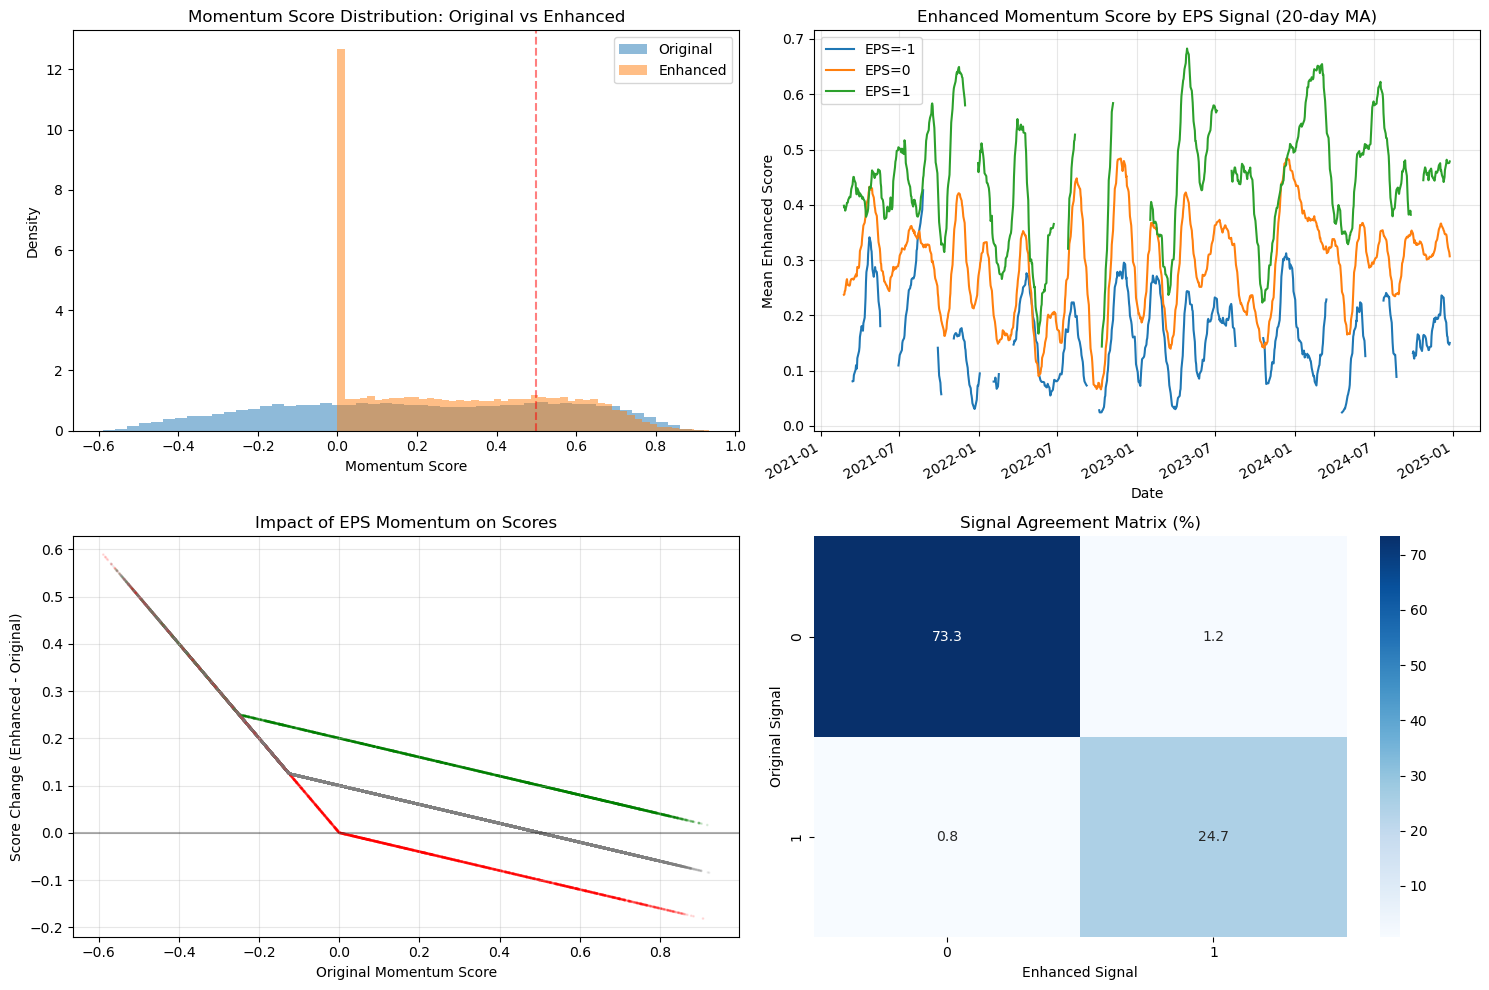


ENHANCEMENT COMPLETE!

ANALYZING EPS MOMENTUM EFFECTIVENESS

1. Loading price data for return calculation...

2. Analyzing predictive improvement...

Information Coefficient Comparison (5-day):
  • Original IC: 0.0084 (t-stat: 1.21)
  • Enhanced IC: 0.0101 (t-stat: 1.47)
  • Improvement: 0.16bps

Directional Accuracy Comparison (5-day):
  • Original accuracy: 49.18%
  • Enhanced accuracy: 49.31%
  • Improvement: 0.1pp

Performance by EPS Momentum Signal:
              ann_return  momentum_score momentum_score_enhanced  count
eps_momentum                                                           
-1                 1.014           0.115                0.166296   4646
 0                 0.530           0.202                0.288289  38359
 1                 1.358           0.288                0.437062   5309

SUMMARY
The EPS momentum feature has been successfully integrated!

Key outputs:
1. hmm_oos_predictions_with_eps_momentum.csv - Enhanced predictions
2. hmm_oos_ticker_summary_enha

In [11]:
# HMM Out-of-Sample Prediction with EPS Momentum Feature
# This script enhances OOS predictions by incorporating earnings momentum signals

import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')


def load_and_prepare_eps_momentum():
    """
    Load and reshape EPS momentum data from wide to long format
    """
    print("Loading EPS Momentum data...")
    
    # Load the EPS momentum file
    eps_data = pd.read_excel('Top_50_EPS_Momentum_2020-2024.xlsx')
    
    # Convert Excel serial dates if needed, otherwise ensure datetime
    if np.issubdtype(eps_data['Dates'].dtype, np.number):
        # Excel serial date → datetime
        eps_data['date'] = (
            pd.to_datetime('1899-12-30') + 
            pd.to_timedelta(eps_data['Dates'], unit='D')
        )
    else:
        # Already datetime or string
        eps_data['date'] = pd.to_datetime(eps_data['Dates'])
    
    # Now melt from wide to long, using the new 'date' column
    eps_long = eps_data.melt(
        id_vars=['date'], 
        var_name='ticker', 
        value_name='eps_momentum'
    )
    
    # Sort by ticker and date
    eps_long = eps_long.sort_values(['ticker', 'date']).reset_index(drop=True)
    
    print(f"✓ Loaded EPS momentum data: {len(eps_long):,} records")
    print(f"✓ Date range: {eps_long['date'].min()} to {eps_long['date'].max()}")
    print(f"✓ Unique tickers: {eps_long['ticker'].nunique()}")
    
    # Check distribution of signals
    signal_dist = eps_long['eps_momentum'].value_counts()
    print("\nEPS Momentum Signal Distribution:")
    print(f"  • Long (+1): {signal_dist.get(1, 0):,} ({signal_dist.get(1, 0)/len(eps_long)*100:.1f}%)")
    print(f"  • Neutral (0): {signal_dist.get(0, 0):,} ({signal_dist.get(0, 0)/len(eps_long)*100:.1f}%)")
    print(f"  • Short (-1): {signal_dist.get(-1, 0):,} ({signal_dist.get(-1, 0)/len(eps_long)*100:.1f}%)")
    
    return eps_long



def enhance_predictions_with_eps_momentum():
    """
    Enhance existing OOS predictions with EPS momentum feature
    """
    print("\n" + "="*70)
    print("ENHANCING OOS PREDICTIONS WITH EPS MOMENTUM")
    print("="*70)
    
    # 1. Load existing OOS predictions
    print("\n1. Loading existing OOS predictions...")
    predictions = pd.read_csv('hmm_daily_scores_complete_2020_2024.csv')
    predictions['date'] = pd.to_datetime(predictions['date'])
    print(f"✓ Loaded {len(predictions):,} prediction records")
    
    # 2. Load and prepare EPS momentum data
    print("\n2. Preparing EPS momentum data...")
    eps_momentum = load_and_prepare_eps_momentum()
    
    # 3. Merge EPS momentum with predictions
    print("\n3. Merging EPS momentum with predictions...")
    
    # Ensure ticker names match (handle potential case differences)
    predictions['ticker_upper'] = predictions['ticker'].str.upper()
    eps_momentum['ticker_upper'] = eps_momentum['ticker'].str.upper()
    
    # Merge on date and ticker
    enhanced_predictions = pd.merge(
        predictions,
        eps_momentum[['date', 'ticker_upper', 'eps_momentum']],
        on=['date', 'ticker_upper'],
        how='left'
    )
    
    # Check merge quality
    merge_success = enhanced_predictions['eps_momentum'].notna().sum()
    merge_rate = merge_success / len(enhanced_predictions) * 100
    print(f"✓ Merge success rate: {merge_rate:.1f}% ({merge_success:,}/{len(enhanced_predictions):,})")
    
    # Handle missing EPS momentum (set to 0/neutral)
    enhanced_predictions['eps_momentum'].fillna(0, inplace=True)
    
    # 4. Create enhanced momentum score
    print("\n4. Creating enhanced momentum score...")
    
    # Original momentum score weight
    original_weight = 0.8
    eps_weight = 0.2
    
    # Create enhanced score
    # EPS momentum contribution: +1 adds positive bias, -1 adds negative bias
    enhanced_predictions['eps_contribution'] = enhanced_predictions['eps_momentum'] * eps_weight
    enhanced_predictions['momentum_score_enhanced'] = (
        enhanced_predictions['momentum_score'] * original_weight + 
        enhanced_predictions['eps_contribution'] * 0.5 +  # Scale down to keep in [0,1] range
        0.5 * (1 - original_weight)  # Recentering
    )
    
    # Ensure scores stay in reasonable range [0, 1]
    enhanced_predictions['momentum_score_enhanced'] = enhanced_predictions['momentum_score_enhanced'].clip(0, 1)
    
    # 5. Calculate improvement statistics
    print("\n5. Enhancement Statistics:")
    print("-"*50)
    
    # Compare original vs enhanced scores
    print(f"Original momentum score:")
    print(f"  • Mean: {enhanced_predictions['momentum_score'].mean():.3f}")
    print(f"  • Std: {enhanced_predictions['momentum_score'].std():.3f}")
    
    print(f"\nEnhanced momentum score:")
    print(f"  • Mean: {enhanced_predictions['momentum_score_enhanced'].mean():.3f}")
    print(f"  • Std: {enhanced_predictions['momentum_score_enhanced'].std():.3f}")
    
    # Correlation between scores
    score_corr = enhanced_predictions['momentum_score'].corr(enhanced_predictions['momentum_score_enhanced'])
    print(f"\nCorrelation between original and enhanced: {score_corr:.3f}")
    
    # Impact of EPS momentum
    eps_impact = enhanced_predictions.groupby('eps_momentum').agg({
        'momentum_score': 'mean',
        'momentum_score_enhanced': 'mean',
        'ticker': 'count'
    }).rename(columns={'ticker': 'count'})
    
    print("\nImpact by EPS momentum signal:")
    print(eps_impact.round(3))
    
    # 6. Create combined signal
    print("\n6. Creating combined signals...")
    
    # Original signal
    enhanced_predictions['signal_original'] = (enhanced_predictions['momentum_score'] > 0.5).astype(int)
    
    # Enhanced signal
    enhanced_predictions['signal_enhanced'] = (enhanced_predictions['momentum_score_enhanced'] > 0.5).astype(int)
    
    # Combined signal (requires both to agree for strong conviction)
    enhanced_predictions['signal_combined'] = np.where(
        (enhanced_predictions['signal_original'] == 1) & (enhanced_predictions['eps_momentum'] >= 0), 1,
        np.where(
            (enhanced_predictions['signal_original'] == 0) & (enhanced_predictions['eps_momentum'] <= 0), 0,
            0.5  # Neutral when signals disagree
        )
    )
    
    # Signal agreement analysis
    signal_agreement = (enhanced_predictions['signal_original'] == enhanced_predictions['signal_enhanced']).mean()
    print(f"\nSignal agreement rate: {signal_agreement:.1%}")
    
    # 7. Export enhanced predictions
    print("\n7. Exporting enhanced predictions...")
    
    # Select columns to export
    export_cols = [
        'date', 'ticker', 
        'momentum_score', 'momentum_score_enhanced',
        'eps_momentum', 'signal_combined',
        'bullish_probability', 'current_state', 'state_label',
        'trend_strength', 'volatility', 'rsi', 
        'vol_skew', 'rolling_sharpe', 'downside_vol'
    ]
    
    enhanced_predictions[export_cols].to_csv('hmm_oos_predictions_with_eps_momentum.csv', index=False)
    print("✓ Exported: hmm_oos_predictions_with_eps_momentum.csv")
    
    # Summary by ticker
    ticker_summary = enhanced_predictions.groupby('ticker').agg({
        'momentum_score': ['mean', 'std'],
        'momentum_score_enhanced': ['mean', 'std'],
        'eps_momentum': ['mean', lambda x: (x > 0).mean() - (x < 0).mean()],  # Net bullishness
        'signal_combined': 'mean'
    }).round(3)
    
    ticker_summary.columns = ['_'.join(col).strip() for col in ticker_summary.columns]
    ticker_summary.to_csv('hmm_oos_ticker_summary_enhanced.csv')
    print("✓ Exported: hmm_oos_ticker_summary_enhanced.csv")
    
    # 8. Visualize enhancement impact
    print("\n8. Creating visualization...")
    
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Score distribution comparison
    ax1 = axes[0, 0]
    ax1.hist(enhanced_predictions['momentum_score'], bins=50, alpha=0.5, label='Original', density=True)
    ax1.hist(enhanced_predictions['momentum_score_enhanced'], bins=50, alpha=0.5, label='Enhanced', density=True)
    ax1.set_xlabel('Momentum Score')
    ax1.set_ylabel('Density')
    ax1.set_title('Momentum Score Distribution: Original vs Enhanced')
    ax1.legend()
    ax1.axvline(x=0.5, color='red', linestyle='--', alpha=0.5)
    
    # 2. Impact by EPS signal
    ax2 = axes[0, 1]
    eps_impact_plot = enhanced_predictions.groupby(['date', 'eps_momentum'])['momentum_score_enhanced'].mean().unstack()
    for col in eps_impact_plot.columns:
        if col in eps_impact_plot:
            eps_impact_plot[col].rolling(20).mean().plot(ax=ax2, label=f'EPS={col}')
    ax2.set_title('Enhanced Momentum Score by EPS Signal (20-day MA)')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Mean Enhanced Score')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Score changes scatter
    ax3 = axes[1, 0]
    score_change = enhanced_predictions['momentum_score_enhanced'] - enhanced_predictions['momentum_score']
    colors = enhanced_predictions['eps_momentum'].map({1: 'green', 0: 'gray', -1: 'red'})
    ax3.scatter(enhanced_predictions['momentum_score'], score_change, 
                c=colors, alpha=0.1, s=1)
    ax3.set_xlabel('Original Momentum Score')
    ax3.set_ylabel('Score Change (Enhanced - Original)')
    ax3.set_title('Impact of EPS Momentum on Scores')
    ax3.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax3.grid(True, alpha=0.3)
    
    # 4. Signal changes
    ax4 = axes[1, 1]
    signal_comparison = pd.crosstab(
        enhanced_predictions['signal_original'], 
        enhanced_predictions['signal_enhanced'],
        normalize='all'
    ) * 100
    
    sns.heatmap(signal_comparison, annot=True, fmt='.1f', cmap='Blues', ax=ax4)
    ax4.set_title('Signal Agreement Matrix (%)')
    ax4.set_xlabel('Enhanced Signal')
    ax4.set_ylabel('Original Signal')
    
    plt.tight_layout()
    plt.savefig('hmm_eps_momentum_enhancement_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n" + "="*70)
    print("ENHANCEMENT COMPLETE!")
    print("="*70)
    
    return enhanced_predictions


def analyze_eps_momentum_effectiveness(enhanced_predictions, price_data_path='OHLCV_2020-12-24_to_2024-12-24_stooq.csv'):
    """
    Analyze how well EPS momentum improves prediction accuracy
    """
    print("\n" + "="*70)
    print("ANALYZING EPS MOMENTUM EFFECTIVENESS")
    print("="*70)
    
    # Load price data for returns
    print("\n1. Loading price data for return calculation...")
    price_data = pd.read_csv(price_data_path)
    price_data.columns = price_data.columns.str.lower()
    price_data['date'] = pd.to_datetime(price_data['date'])
    
    # Calculate forward returns
    price_data = price_data.sort_values(['ticker', 'date'])
    for horizon in [1, 5, 10, 20]:
        price_data[f'fwd_return_{horizon}d'] = (
            price_data.groupby('ticker')['close']
            .pct_change(horizon)
            .shift(-horizon)
        )
    
    # Merge with predictions
    print("\n2. Analyzing predictive improvement...")
    analysis_df = pd.merge(
        enhanced_predictions,
        price_data[['date', 'ticker', 'fwd_return_5d']],
        on=['date', 'ticker'],
        how='inner'
    )
    
    # Calculate IC for different score types
    print("\nInformation Coefficient Comparison (5-day):")
    
    # Group by date and calculate correlations
    ic_original = analysis_df.groupby('date').apply(
        lambda x: x['momentum_score'].corr(x['fwd_return_5d']) if len(x) > 5 else np.nan
    ).dropna()
    
    ic_enhanced = analysis_df.groupby('date').apply(
        lambda x: x['momentum_score_enhanced'].corr(x['fwd_return_5d']) if len(x) > 5 else np.nan
    ).dropna()
    
    print(f"  • Original IC: {ic_original.mean():.4f} (t-stat: {ic_original.mean()/(ic_original.std()/np.sqrt(len(ic_original))):.2f})")
    print(f"  • Enhanced IC: {ic_enhanced.mean():.4f} (t-stat: {ic_enhanced.mean()/(ic_enhanced.std()/np.sqrt(len(ic_enhanced))):.2f})")
    print(f"  • Improvement: {(ic_enhanced.mean() - ic_original.mean())*100:.2f}bps")
    
    # Directional accuracy
    print("\nDirectional Accuracy Comparison (5-day):")
    
    analysis_df['actual_direction'] = (analysis_df['fwd_return_5d'] > 0).astype(int)
    analysis_df['pred_direction_original'] = (analysis_df['momentum_score'] > 0.5).astype(int)
    analysis_df['pred_direction_enhanced'] = (analysis_df['momentum_score_enhanced'] > 0.5).astype(int)
    
    acc_original = (analysis_df['pred_direction_original'] == analysis_df['actual_direction']).mean()
    acc_enhanced = (analysis_df['pred_direction_enhanced'] == analysis_df['actual_direction']).mean()
    
    print(f"  • Original accuracy: {acc_original:.2%}")
    print(f"  • Enhanced accuracy: {acc_enhanced:.2%}")
    print(f"  • Improvement: {(acc_enhanced - acc_original)*100:.1f}pp")
    
    # Performance by EPS momentum signal
    print("\nPerformance by EPS Momentum Signal:")
    perf_by_eps = analysis_df.groupby('eps_momentum').agg({
        'fwd_return_5d': 'mean',
        'momentum_score': 'mean',
        'momentum_score_enhanced': 'mean',
        'ticker': 'count'
    }).rename(columns={'ticker': 'count'})
    
    perf_by_eps['ann_return'] = perf_by_eps['fwd_return_5d'] * 252
    print(perf_by_eps[['ann_return', 'momentum_score', 'momentum_score_enhanced', 'count']].round(3))
    
    return {
        'ic_original': ic_original.mean(),
        'ic_enhanced': ic_enhanced.mean(),
        'acc_original': acc_original,
        'acc_enhanced': acc_enhanced
    }


# Main execution
if __name__ == "__main__":
    # Run enhancement
    enhanced_predictions = enhance_predictions_with_eps_momentum()
    
    # Analyze effectiveness
    effectiveness = analyze_eps_momentum_effectiveness(enhanced_predictions)
    
    print("\n" + "="*70)
    print("SUMMARY")
    print("="*70)
    print("The EPS momentum feature has been successfully integrated!")
    print("\nKey outputs:")
    print("1. hmm_oos_predictions_with_eps_momentum.csv - Enhanced predictions")
    print("2. hmm_oos_ticker_summary_enhanced.csv - Summary by ticker")
    print("3. hmm_eps_momentum_enhancement_analysis.png - Visual analysis")
    
    print("\nNext steps:")
    print("1. Compare enhanced vs original predictions using the evaluation framework")
    print("2. Consider retraining the HMM model with EPS momentum as an additional feature")
    print("3. Test different weighting schemes for combining signals")

OPTIMIZING EPS MOMENTUM WEIGHTS

1. Loading data...

2. Merging data...
✓ Final dataset: 48,069 observations

3. Running grid search...

Optimal weights found:
  • HMM weight: 0.50
  • EPS weight: 0.50
  • IC: 0.0123


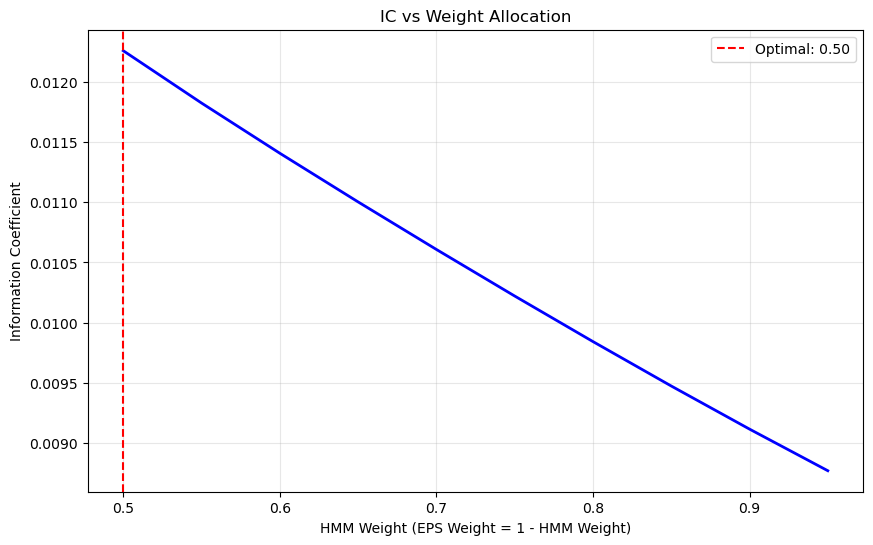


CREATING INTERACTION FEATURES

1. Creating interaction features...

2. Feature statistics:
  • Momentum alignment rate: 51.47%
  • High conviction signals: 8.03%
  • EPS momentum changes: 8.19%

✓ Exported: hmm_oos_predictions_interaction_features.csv

CREATING DYNAMIC WEIGHTING SYSTEM

CREATING INTERACTION FEATURES

1. Creating interaction features...

2. Feature statistics:
  • Momentum alignment rate: 51.47%
  • High conviction signals: 8.03%
  • EPS momentum changes: 8.19%

✓ Exported: hmm_oos_predictions_interaction_features.csv

3. Creating dynamic weights...

4. Dynamic weighting statistics:
  • Average EPS weight: 25.55%
  • EPS weight range: [12.81%, 37.50%]


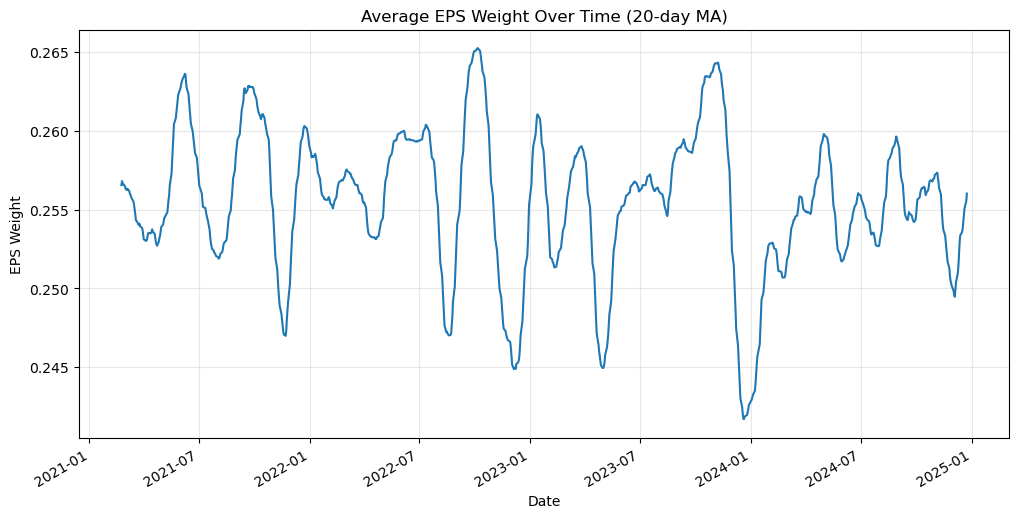


✓ Exported: hmm_oos_predictions_dynamic_weights.csv

ENHANCEMENT STRATEGIES COMPLETE!

Recommendations:
1. Use optimal static weights: HMM=0.50, EPS=0.50
2. Consider interaction features for regime-specific enhancements
3. Implement dynamic weighting based on market conditions
4. Test conviction-based position sizing using alignment scores


In [4]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

def optimize_eps_momentum_weights(predictions_path='hmm_daily_scores_complete_2020_2024.csv',
                                 eps_data_path='Top_50_EPS_Momentum_2020-2024.xlsx',
                                 price_data_path='OHLCV_2020-12-24_to_2024-12-24_stooq.csv'):
    """
    Find optimal weights for combining HMM momentum and EPS momentum
    """
    print("="*70)
    print("OPTIMIZING EPS MOMENTUM WEIGHTS")
    print("="*70)
    
    # Load data
    print("\n1. Loading data...")
    predictions = pd.read_csv(predictions_path)
    predictions['date'] = pd.to_datetime(predictions['date'])
    
    # Load and prepare EPS momentum
    eps_data = pd.read_excel(eps_data_path)
    if np.issubdtype(eps_data['Dates'].dtype, np.number):
        eps_data['date'] = pd.to_datetime('1899-12-30') + pd.to_timedelta(eps_data['Dates'], unit='D')
    else:
        eps_data['date'] = pd.to_datetime(eps_data['Dates'])
    
    eps_long = eps_data.melt(id_vars=['date'], var_name='ticker', value_name='eps_momentum')
    
    # Load price data
    price_data = pd.read_csv(price_data_path)
    price_data.columns = price_data.columns.str.lower()
    price_data['date'] = pd.to_datetime(price_data['date'])
    
    # Calculate forward returns
    price_data = price_data.sort_values(['ticker', 'date'])
    price_data['fwd_return_5d'] = (
        price_data.groupby('ticker')['close']
        .pct_change(5)
        .shift(-5)
    )
    
    # Merge all data
    print("\n2. Merging data...")
    predictions['ticker_upper'] = predictions['ticker'].str.upper()
    eps_long['ticker_upper'] = eps_long['ticker'].str.upper()
    
    merged = pd.merge(predictions, eps_long[['date', 'ticker_upper', 'eps_momentum']], 
                     on=['date', 'ticker_upper'], how='left')
    merged['eps_momentum'].fillna(0, inplace=True)
    
    merged = pd.merge(merged, price_data[['date', 'ticker', 'fwd_return_5d']], 
                     on=['date', 'ticker'], how='inner')
    merged = merged.dropna(subset=['fwd_return_5d'])
    
    print(f"✓ Final dataset: {len(merged):,} observations")
    
    # Define objective function (negative IC)
    def objective(weights):
        hmm_weight, eps_weight = weights
        
        # Normalize weights
        total = hmm_weight + eps_weight
        hmm_weight = hmm_weight / total
        eps_weight = eps_weight / total
        
        # Create combined score
        combined_score = (
            merged['momentum_score'] * hmm_weight +
            (merged['eps_momentum'] * 0.5 + 0.5) * eps_weight
        )
        
        # Calculate IC
        ic_by_date = merged.groupby('date').apply(
            lambda x: combined_score[x.index].corr(x['fwd_return_5d']) 
            if len(x) > 5 else np.nan
        ).dropna()
        
        return -ic_by_date.mean()  # Negative because we minimize
    
    # Grid search
    print("\n3. Running grid search...")
    hmm_weights = np.arange(0.5, 1.0, 0.05)
    eps_weights = 1 - hmm_weights
    
    results = []
    for hmm_w, eps_w in zip(hmm_weights, eps_weights):
        ic = -objective([hmm_w, eps_w])
        results.append({
            'hmm_weight': hmm_w,
            'eps_weight': eps_w,
            'ic': ic
        })
    
    results_df = pd.DataFrame(results)
    optimal = results_df.loc[results_df['ic'].idxmax()]
    
    print(f"\nOptimal weights found:")
    print(f"  • HMM weight: {optimal['hmm_weight']:.2f}")
    print(f"  • EPS weight: {optimal['eps_weight']:.2f}")
    print(f"  • IC: {optimal['ic']:.4f}")
    
    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(results_df['hmm_weight'], results_df['ic'], 'b-', linewidth=2)
    plt.axvline(x=optimal['hmm_weight'], color='r', linestyle='--', 
                label=f'Optimal: {optimal["hmm_weight"]:.2f}')
    plt.xlabel('HMM Weight (EPS Weight = 1 - HMM Weight)')
    plt.ylabel('Information Coefficient')
    plt.title('IC vs Weight Allocation')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('eps_weight_optimization.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return optimal


def create_interaction_features(predictions_path='hmm_daily_scores_complete_2020_2024.csv',
                               eps_data_path='Top_50_EPS_Momentum_2020-2024.xlsx'):
    """
    Create interaction features between HMM states and EPS momentum
    """
    print("\n" + "="*70)
    print("CREATING INTERACTION FEATURES")
    print("="*70)
    
    # Load data
    predictions = pd.read_csv(predictions_path)
    predictions['date'] = pd.to_datetime(predictions['date'])
    
    # Load EPS momentum
    eps_data = pd.read_excel(eps_data_path)
    if np.issubdtype(eps_data['Dates'].dtype, np.number):
        eps_data['date'] = pd.to_datetime('1899-12-30') + pd.to_timedelta(eps_data['Dates'], unit='D')
    else:
        eps_data['date'] = pd.to_datetime(eps_data['Dates'])
    
    eps_long = eps_data.melt(id_vars=['date'], var_name='ticker', value_name='eps_momentum')
    
    # Merge
    predictions['ticker_upper'] = predictions['ticker'].str.upper()
    eps_long['ticker_upper'] = eps_long['ticker'].str.upper()
    
    enhanced = pd.merge(predictions, eps_long[['date', 'ticker_upper', 'eps_momentum']], 
                       on=['date', 'ticker_upper'], how='left')
    enhanced['eps_momentum'].fillna(0, inplace=True)
    
    print("\n1. Creating interaction features...")
    
    # 1. State-EPS interaction
    enhanced['state_eps_interaction'] = enhanced['state_label'].astype(str) + '_EPS' + enhanced['eps_momentum'].astype(str)
    
    # 2. Momentum alignment score
    enhanced['momentum_alignment'] = np.where(
        (enhanced['momentum_score'] > 0.5) & (enhanced['eps_momentum'] > 0), 1.0,
        np.where(
            (enhanced['momentum_score'] < 0.5) & (enhanced['eps_momentum'] < 0), 1.0,
            np.where(
                enhanced['eps_momentum'] == 0, 0.5,
                0.0  # Disagreement
            )
        )
    )
    
    # 3. Conviction score (both signals strong in same direction)
    enhanced['conviction_score'] = np.where(
        (enhanced['momentum_score'] > 0.7) & (enhanced['eps_momentum'] == 1), 1.0,
        np.where(
            (enhanced['momentum_score'] < 0.3) & (enhanced['eps_momentum'] == -1), -1.0,
            0.0
        )
    )
    
    # 4. EPS momentum change
    enhanced['eps_momentum_change'] = enhanced.groupby('ticker')['eps_momentum'].diff()
    
    # 5. Regime-specific enhancement
    bullish_states = ['High Growth', 'Bullish', 'Volatile Bull']
    bearish_states = ['Bearish', 'Mild Bear']
    
    enhanced['regime_eps_boost'] = np.where(
        enhanced['state_label'].isin(bullish_states) & (enhanced['eps_momentum'] > 0),
        enhanced['momentum_score'] * 1.2,
        np.where(
            enhanced['state_label'].isin(bearish_states) & (enhanced['eps_momentum'] < 0),
            enhanced['momentum_score'] * 0.8,
            enhanced['momentum_score']
        )
    ).clip(0, 1)
    
    print("\n2. Feature statistics:")
    print(f"  • Momentum alignment rate: {enhanced['momentum_alignment'].mean():.2%}")
    print(f"  • High conviction signals: {(enhanced['conviction_score'].abs() == 1).mean():.2%}")
    print(f"  • EPS momentum changes: {(enhanced['eps_momentum_change'] != 0).mean():.2%}")
    
    # Export enhanced features
    enhanced.to_csv('hmm_oos_predictions_interaction_features.csv', index=False)
    print("\n✓ Exported: hmm_oos_predictions_interaction_features.csv")
    
    return enhanced


def create_dynamic_weighting(predictions_path='hmm_daily_scores_complete_2020_2024.csv',
                           eps_data_path='Top_50_EPS_Momentum_2020-2024.xlsx'):
    """
    Create dynamic weighting based on market conditions
    """
    print("\n" + "="*70)
    print("CREATING DYNAMIC WEIGHTING SYSTEM")
    print("="*70)
    
    # Load enhanced predictions with interaction features
    enhanced = create_interaction_features(predictions_path, eps_data_path)
    
    print("\n3. Creating dynamic weights...")
    
    # 1. Volatility-based weighting (trust EPS more in high vol)
    vol_percentile = enhanced.groupby('date')['volatility'].transform(
        lambda x: x.rank(pct=True)
    )
    
    # Higher EPS weight when volatility is high
    enhanced['eps_weight_dynamic'] = 0.1 + 0.3 * vol_percentile
    enhanced['hmm_weight_dynamic'] = 1 - enhanced['eps_weight_dynamic']
    
    # 2. Regime-based weighting
    regime_eps_weights = {
        'High Growth': 0.15,      # Trust momentum more
        'Bullish': 0.20,          
        'Volatile Bull': 0.30,    # Trust EPS more in volatile times
        'Sideways': 0.35,         # EPS more important when directionless
        'Choppy': 0.35,
        'Bearish': 0.25,
        'Mild Bear': 0.25,
        'Weak Bull': 0.30
    }
    
    enhanced['regime_eps_weight'] = enhanced['state_label'].map(regime_eps_weights).fillna(0.25)
    
    # 3. Combine dynamic weights
    enhanced['final_eps_weight'] = (
        enhanced['eps_weight_dynamic'] * 0.5 + 
        enhanced['regime_eps_weight'] * 0.5
    )
    
    # 4. Create dynamically weighted score
    enhanced['momentum_score_dynamic'] = (
        enhanced['momentum_score'] * (1 - enhanced['final_eps_weight']) +
        (enhanced['eps_momentum'] * 0.5 + 0.5) * enhanced['final_eps_weight']
    )
    
    print("\n4. Dynamic weighting statistics:")
    print(f"  • Average EPS weight: {enhanced['final_eps_weight'].mean():.2%}")
    print(f"  • EPS weight range: [{enhanced['final_eps_weight'].min():.2%}, {enhanced['final_eps_weight'].max():.2%}]")
    
    # Visualize dynamic weights over time
    plt.figure(figsize=(12, 6))
    enhanced.groupby('date')['final_eps_weight'].mean().rolling(20).mean().plot()
    plt.title('Average EPS Weight Over Time (20-day MA)')
    plt.xlabel('Date')
    plt.ylabel('EPS Weight')
    plt.grid(True, alpha=0.3)
    plt.savefig('dynamic_eps_weights.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Export
    enhanced.to_csv('hmm_oos_predictions_dynamic_weights.csv', index=False)
    print("\n✓ Exported: hmm_oos_predictions_dynamic_weights.csv")
    
    return enhanced


# Main execution
if __name__ == "__main__":
    # 1. Find optimal static weights
    optimal_weights = optimize_eps_momentum_weights()
    
    # 2. Create interaction features
    interaction_features = create_interaction_features()
    
    # 3. Create dynamic weighting system
    dynamic_predictions = create_dynamic_weighting()
    
    print("\n" + "="*70)
    print("ENHANCEMENT STRATEGIES COMPLETE!")
    print("="*70)
    print("\nRecommendations:")
    print(f"1. Use optimal static weights: HMM={optimal_weights['hmm_weight']:.2f}, EPS={optimal_weights['eps_weight']:.2f}")
    print("2. Consider interaction features for regime-specific enhancements")
    print("3. Implement dynamic weighting based on market conditions")
    print("4. Test conviction-based position sizing using alignment scores")